In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Finance Stocks LSTM Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Prepare Test Data

In [8]:
nr_test_sets = ['FBP','AFG','JPM']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2019-01-22         9.50  9.028269  -2.255619  11013900.0     2.0
2019-01-23         9.40  9.085459 -15.384672   9894000.0     2.0
2019-01-24         9.41  9.135388 -14.615424  11127300.0     2.0
2019-01-25         9.64  9.213021  -0.854639  12071100.0     2.0
2019-01-28         9.74  9.294094  -9.599991  13124000.0     2.0
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    95.959999  92.750365  -1.891883  2019300.0     2.0
2019-01-23    95.279999  93.139539 -17.336730  1754000.0     2.0
2019-01-24    95.690002  93.531918 -12.247481  2036400.0     2.0
2019-01-25    95.019997  93.760853 -21.494180  1640100.0     2.0
2019-01-28    94.750000  93.913030 -25.032797  1462200.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                   

In [9]:
r_test_sets = ['FBP','AFG','JPM']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
        
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2020-01-22        10.16  10.378210 -80.303008 -2725500.0     2.0
2020-01-23        10.12  10.338485 -84.615464 -4799800.0     2.0
2020-01-24        10.17  10.312565 -73.770502 -3020800.0     2.0
2020-01-27        10.01  10.266016 -83.561649 -4665400.0     2.0
2020-01-28         9.87  10.205091 -87.209337 -6089900.0     2.0
            previous_1d      EMA_12   willr_14     OBV_7  labels
Date                                                            
2020-01-22   110.709999  110.318220 -37.234155  495600.0     2.0
2020-01-23   110.660004  110.370802 -39.007042   43700.0     2.0
2020-01-24   110.239998  110.350678 -53.900867 -231100.0     2.0
2020-01-27   110.489998  110.372112 -45.035617   27900.0     1.0
2020-01-28   108.529999  110.088710 -98.475749 -331600.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                   

## Train First BanCorp Stock Data

### Creating Training Data and Model

            previous_1d      EMA_12  willr_14    OBV_7  labels
Date                                                          
2000-01-21     100.0000  100.813609     -64.0 -21460.0     2.0
2000-01-24      97.1875  100.255746    -100.0 -28200.0     2.0
2000-01-25      96.2500   99.639478    -100.0 -32420.0     2.0
2000-01-26      93.1250   98.637250    -100.0 -42580.0     2.0
2000-01-27      94.0625   97.933443     -90.0 -36840.0     2.0


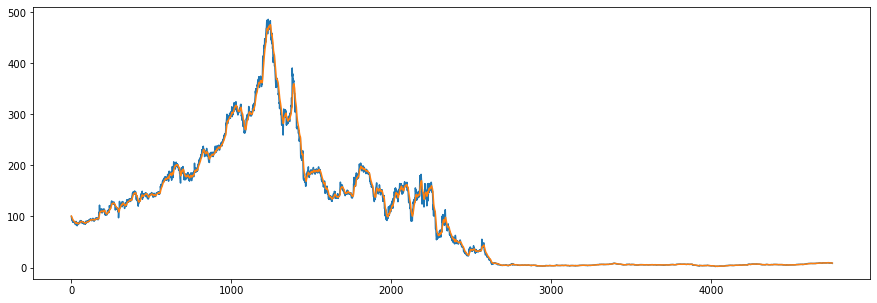

(4745, 15, 4)

In [10]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/FBP_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['FBP','AFG','JPM']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'FirstBanCorpModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'FirstBanCorpModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3140655105973025, 1: 7.3140655105973025, 2: 0.36676328502415456}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/30 [>.............................] - ETA: 0s - loss: 0.3627 - accuracy: 0.5312 - mse: 0.3358 - weighted_accuracy: 0.3148 - weighted_mse: 0.4775WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 44ms/step - loss: 0.2940 - accuracy: 0.5129 - mse: 0.4421 - weighted_accuracy: 0.2961 - weighted_mse: 0.5287 - val_loss: 0.2993 - val_accuracy: 0.0464 - val_mse: 0.3550 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3550
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2122 - accuracy: 0.3851 - mse: 0.7692 - weighted_accuracy: 0.4304 - weighted_mse: 0.7657 - val_loss: 0.2902

7/7 [==============================] - 0s 3ms/step - loss: 0.1790 - accuracy: 0.4155 - mse: 1.3082 - weighted_accuracy: 0.4155 - weighted_mse: 1.3082
Test loss: 0.1789560765028
Test accuracy: 0.4155251085758209


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 66
actual holds but predicted sell: 51
actual predicted holds: 80
Percentage buys correct: 9.333333333333334%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 90.9090909090909%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 48.0%
Percentage high sells correct: 58.18181818181818%
Percentage mid holds correct: 85.22727272727273%


Capital: 100
Share price: $0.997522336335424
Shares owned at the moment: 99
Cash capital at the moment: $0.9737132467257084


Price increase from previo

7/7 [==============================] - 0s 3ms/step - loss: 0.1814 - accuracy: 0.4292 - mse: 1.2688 - weighted_accuracy: 0.4292 - weighted_mse: 1.2688
Test loss: 0.18143825232982635
Test accuracy: 0.4292237460613251


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 68
actual holds but predicted sell: 48
actual predicted holds: 81
Percentage buys correct: 6.756756756756757%
Percentage sells correct: 13.559322033898304%
Percentage holds correct: 94.18604651162791%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 43.83561643835616%
Percentage high sells correct: 54.23728813559322%
Percentage mid holds correct: 89.53488372093024%


Capital: 100
Share price: $0.9747668796402857
Shares owned at the moment: 102
Cash capital at the moment: $0.30035616695175804


Pric

7/7 [==============================] - 0s 3ms/step - loss: 0.1811 - accuracy: 0.4110 - mse: 1.2722 - weighted_accuracy: 0.4110 - weighted_mse: 1.2722
Test loss: 0.18113689124584198
Test accuracy: 0.4109589159488678


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 61
actual holds but predicted sell: 56
actual predicted holds: 80
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 6.557377049180328%
Percentage holds correct: 90.9090909090909%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 45.714285714285715%
Percentage high sells correct: 47.540983606557376%
Percentage mid holds correct: 82.75862068965517%


Capital: 100
Share price: $1.0100000000000002
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999854


Price 

Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.4233 - mse: 1.5622 - weighted_accuracy: 0.7061 - weighted_mse: 1.4797 - val_loss: 0.1864 - val_accuracy: 0.3994 - val_mse: 1.5681 - val_weighted_accuracy: 0.3994 - val_weighted_mse: 1.5681
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1398 - accuracy: 0.4331 - mse: 1.5799 - weighted_accuracy: 0.6932 - weighted_mse: 1.4991 - val_loss: 0.1914 - val_accuracy: 0.3878 - val_mse: 1.5868 - val_weighted_accuracy: 0.3878 - val_weighted_mse: 1.5868
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1386 - accuracy: 0.4302 - mse: 1.5907 - weighted_accuracy: 0.7068 - weighted_mse: 1.5042 - val_loss: 0.1898 - val_accuracy: 0.3857 - val_mse: 1.6295 - val_weighted_accuracy: 0.3857 - val_weighted_mse: 1.6295
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1369 - accuracy: 0.4268 - mse: 1.6066 - weighted_accuracy: 0.7019 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1815 - accuracy: 0.4475 - mse: 1.8472 - weighted_accuracy: 0.4475 - weighted_mse: 1.8472
Test loss: 0.18146763741970062
Test accuracy: 0.44748857617378235


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 44
actual holds but predicted sell: 67
actual predicted holds: 86
Percentage buys correct: 12.0%
Percentage sells correct: 8.219178082191782%
Percentage holds correct: 89.58333333333333%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 52.0%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 85.41666666666667%


Capital: 100
Share price: $0.997522336335424
Shares owned at the moment: 99
Cash capital at the moment: $0.9737132467257084


Price increase from previously bo

7/7 [==============================] - 0s 3ms/step - loss: 0.1856 - accuracy: 0.4521 - mse: 1.7620 - weighted_accuracy: 0.4521 - weighted_mse: 1.7620
Test loss: 0.18556725978851318
Test accuracy: 0.45205479860305786


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 2
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 43
actual holds but predicted sell: 62
actual predicted holds: 92
Percentage buys correct: 0.0%
Percentage sells correct: 9.859154929577464%
Percentage holds correct: 88.46153846153847%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 39.53488372093023%
Percentage high sells correct: 54.929577464788736%
Percentage mid holds correct: 85.57692307692308%


Capital: 100
Share price: $0.821695020512681
Shares owned at the moment: 121
Cash capital at the moment: $0.30148349989001133


Price increase fro

7/7 [==============================] - 0s 2ms/step - loss: 0.1795 - accuracy: 0.4795 - mse: 1.7363 - weighted_accuracy: 0.4795 - weighted_mse: 1.7363
Test loss: 0.17945562303066254
Test accuracy: 0.4794520437717438


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 7
actual holds but predicted buy: 37
actual holds but predicted sell: 62
actual predicted holds: 98
Percentage buys correct: 5.128205128205129%
Percentage sells correct: 7.352941176470588%
Percentage holds correct: 87.5%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.18018018018019%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from previously bou

30/30 [==============================] - 0s 8ms/step - loss: 0.1198 - accuracy: 0.5464 - mse: 1.8552 - weighted_accuracy: 0.7824 - weighted_mse: 1.7924 - val_loss: 0.1778 - val_accuracy: 0.4995 - val_mse: 1.9125 - val_weighted_accuracy: 0.4995 - val_weighted_mse: 1.9125
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1183 - accuracy: 0.5514 - mse: 1.8829 - weighted_accuracy: 0.7860 - weighted_mse: 1.8179 - val_loss: 0.1719 - val_accuracy: 0.5269 - val_mse: 1.9532 - val_weighted_accuracy: 0.5269 - val_weighted_mse: 1.9532
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1178 - accuracy: 0.5630 - mse: 1.8907 - weighted_accuracy: 0.7958 - weighted_mse: 1.8308 - val_loss: 0.2062 - val_accuracy: 0.3678 - val_mse: 1.9440 - val_weighted_accuracy: 0.3678 - val_weighted_mse: 1.9440
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1171 - accuracy: 0.5466 - mse: 1.9060 - weighted_accuracy: 0.7843 - weighted_mse: 1.8465

0          -8.209536  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1856 - accuracy: 0.5321 - mse: 2.1993 - weighted_accuracy: 0.5321 - weighted_mse: 2.1993
Test loss: 0.18556655943393707
Test accuracy: 0.5321100950241089


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 5
actual holds but predicted buy: 28
actual holds but predicted sell: 63
actual predicted holds: 106
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 9.859154929577464%
Percentage holds correct: 91.37931034482759%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 61.29032258064516%
Percentage high sells correct: 50.70422535211268%
Percentage mid holds correct: 84.34782608695652%


Capital: 100
Share price: $0.1057943415035869
Shares owned at the moment: 942
Cash capital at 

7/7 [==============================] - 0s 3ms/step - loss: 0.1833 - accuracy: 0.4174 - mse: 2.1830 - weighted_accuracy: 0.4174 - weighted_mse: 2.1830
Test loss: 0.18329216539859772
Test accuracy: 0.41743120551109314


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 35
actual holds but predicted sell: 81
actual predicted holds: 85
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 3.5714285714285716%
Percentage holds correct: 88.54166666666667%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 48.80952380952381%
Percentage mid holds correct: 81.05263157894737%


Capital: 100
Share price: $0.10350315623739602
Shares owned at the moment: 963
Cash capital at the moment: $0.05235830988195289


Pri




RUNNING EPOCHS 60 - 80



Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1107 - accuracy: 0.6083 - mse: 2.0303 - weighted_accuracy: 0.8142 - weighted_mse: 1.9845 - val_loss: 0.1970 - val_accuracy: 0.4468 - val_mse: 2.1217 - val_weighted_accuracy: 0.4468 - val_weighted_mse: 2.1217
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1097 - accuracy: 0.6048 - mse: 2.0534 - weighted_accuracy: 0.8130 - weighted_mse: 2.0044 - val_loss: 0.1779 - val_accuracy: 0.5132 - val_mse: 2.2128 - val_weighted_accuracy: 0.5132 - val_weighted_mse: 2.2128
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1089 - accuracy: 0.6088 - mse: 2.0676 - weighted_accuracy: 0.8199 - weighted_mse: 2.0160 - val_loss: 0.1985 - val_accuracy: 0.4636 - val_mse: 2.2450 - val_weighted_accuracy: 0.4636 - val_weighted_mse: 2.2450
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1085 - accuracy: 0.6267 - mse: 2.0948 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.1518 - accuracy: 0.6849 - mse: 2.6736 - weighted_accuracy: 0.6849 - weighted_mse: 2.6736
Test loss: 0.15177690982818604
Test accuracy: 0.6849315166473389


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 19
actual holds but predicted sell: 36
actual predicted holds: 142
Percentage buys correct: 20.833333333333332%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 91.02564102564102%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 64.1025641025641%
Percentage mid holds correct: 83.2258064516129%


Capital: 100
Share price: $0.997522336335424
Shares owned at the moment: 99
Cash capital at the moment: $0.9737132467257084


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.6119 - mse: 2.5325 - weighted_accuracy: 0.6119 - weighted_mse: 2.5325
Test loss: 0.1579715460538864
Test accuracy: 0.611872136592865


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 32
actual holds but predicted sell: 36
actual predicted holds: 129
Percentage buys correct: 0.0%
Percentage sells correct: 11.904761904761905%
Percentage holds correct: 89.58333333333333%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 34.375%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 85.41666666666667%


Capital: 100
Share price: $0.821695020512681
Shares owned at the moment: 121
Cash capital at the moment: $0.30148349989001133


Price increase from previousl

7/7 [==============================] - 0s 3ms/step - loss: 0.1530 - accuracy: 0.6575 - mse: 2.3960 - weighted_accuracy: 0.6575 - weighted_mse: 2.3960
Test loss: 0.15300987660884857
Test accuracy: 0.6575342416763306


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 24
actual holds but predicted sell: 34
actual predicted holds: 139
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 89.6774193548387%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 44.73684210526316%
Percentage mid holds correct: 81.16883116883118%


Capital: 100
Share price: $1.0100000000000002
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999854


Price 

30/30 [==============================] - 0s 8ms/step - loss: 0.0820 - accuracy: 0.7384 - mse: 2.8583 - weighted_accuracy: 0.8858 - weighted_mse: 2.8457 - val_loss: 0.1713 - val_accuracy: 0.6101 - val_mse: 2.9887 - val_weighted_accuracy: 0.6101 - val_weighted_mse: 2.9887
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0805 - accuracy: 0.7366 - mse: 2.8529 - weighted_accuracy: 0.8832 - weighted_mse: 2.8169 - val_loss: 0.1632 - val_accuracy: 0.6396 - val_mse: 2.9894 - val_weighted_accuracy: 0.6396 - val_weighted_mse: 2.9894
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0818 - accuracy: 0.7492 - mse: 2.9539 - weighted_accuracy: 0.8861 - weighted_mse: 2.9146 - val_loss: 0.1653 - val_accuracy: 0.6481 - val_mse: 2.9997 - val_weighted_accuracy: 0.6481 - val_weighted_mse: 2.9997
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0803 - accuracy: 0.7474 - mse: 2.9182 - weighted_accuracy: 0.8927 - weighted_mse: 2.8841

0          -8.209536  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1732 - accuracy: 0.6697 - mse: 3.4214 - weighted_accuracy: 0.6697 - weighted_mse: 3.4214
Test loss: 0.1731852889060974
Test accuracy: 0.6697247624397278


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 7
actual holds but predicted buy: 16
actual holds but predicted sell: 42
actual predicted holds: 139
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 10.416666666666666%
Percentage holds correct: 91.44736842105263%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 85.43046357615894%


Capital: 100
Share price: $0.1057943415035869
Shares owned at the moment: 942
Cash capital at the moment:

7/7 [==============================] - 0s 3ms/step - loss: 0.1643 - accuracy: 0.6422 - mse: 3.2560 - weighted_accuracy: 0.6422 - weighted_mse: 3.2560
Test loss: 0.1643342226743698
Test accuracy: 0.642201840877533


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 4
actual holds but predicted buy: 24
actual holds but predicted sell: 42
actual predicted holds: 135
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 91.83673469387755%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 43.18181818181818%
Percentage mid holds correct: 84.24657534246575%


Capital: 100
Share price: $0.10350315623739602
Shares owned at the moment: 963
Cash capital at the moment: $0.05235830988195289


Price 

Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0765 - accuracy: 0.7640 - mse: 3.1912 - weighted_accuracy: 0.8951 - weighted_mse: 3.1145 - val_loss: 0.2062 - val_accuracy: 0.5501 - val_mse: 3.3398 - val_weighted_accuracy: 0.5501 - val_weighted_mse: 3.3398
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0750 - accuracy: 0.7482 - mse: 3.2031 - weighted_accuracy: 0.8948 - weighted_mse: 3.1581 - val_loss: 0.1943 - val_accuracy: 0.6006 - val_mse: 3.3116 - val_weighted_accuracy: 0.6006 - val_weighted_mse: 3.3116
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0731 - accuracy: 0.7866 - mse: 3.2404 - weighted_accuracy: 0.8998 - weighted_mse: 3.1709 - val_loss: 0.1726 - val_accuracy: 0.6407 - val_mse: 3.3819 - val_weighted_accuracy: 0.6407 - val_weighted_mse: 3.3819
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0719 - accuracy: 0.7727 - mse: 3.2757 - weighted_accuracy: 0.9038 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1662 - accuracy: 0.7248 - mse: 4.3753 - weighted_accuracy: 0.7248 - weighted_mse: 4.3753
Test loss: 0.16621603071689606
Test accuracy: 0.7247706651687622


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 17
actual holds but predicted sell: 24
actual predicted holds: 156
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 4.0%
Percentage holds correct: 89.14285714285714%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 52.0%
Percentage mid holds correct: 85.05747126436782%


Capital: 100
Share price: $0.11981290606354043
Shares owned at the moment: 832
Cash capital at the moment: $0.04153022606098489


Price increase from previously bought: -4.6

2        1576.179166  


Recession


7/7 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.8750 - mse: 4.4455 - weighted_accuracy: 0.8750 - weighted_mse: 4.445 - 0s 3ms/step - loss: 0.1592 - accuracy: 0.7580 - mse: 3.7984 - weighted_accuracy: 0.7580 - weighted_mse: 3.7984
Test loss: 0.15917260944843292
Test accuracy: 0.7579908967018127


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 18
actual holds but predicted sell: 16
actual predicted holds: 163
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 90.05524861878453%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 81.666

30/30 [==============================] - 0s 8ms/step - loss: 0.0543 - accuracy: 0.8480 - mse: 4.5022 - weighted_accuracy: 0.9369 - weighted_mse: 4.2944 - val_loss: 0.1808 - val_accuracy: 0.6891 - val_mse: 4.5872 - val_weighted_accuracy: 0.6891 - val_weighted_mse: 4.5872
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0528 - accuracy: 0.8496 - mse: 4.5141 - weighted_accuracy: 0.9393 - weighted_mse: 4.2666 - val_loss: 0.1641 - val_accuracy: 0.7229 - val_mse: 4.8062 - val_weighted_accuracy: 0.7229 - val_weighted_mse: 4.8062
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0538 - accuracy: 0.8559 - mse: 4.7410 - weighted_accuracy: 0.9380 - weighted_mse: 4.4663 - val_loss: 0.1771 - val_accuracy: 0.7123 - val_mse: 4.9010 - val_weighted_accuracy: 0.7123 - val_weighted_mse: 4.9010
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0543 - accuracy: 0.8451 - mse: 4.6559 - weighted_accuracy: 0.9340 - weighted_mse: 4.4145

7/7 [==============================] - 0s 3ms/step - loss: 0.1773 - accuracy: 0.7385 - mse: 5.7202 - weighted_accuracy: 0.7385 - weighted_mse: 5.7202
Test loss: 0.17728166282176971
Test accuracy: 0.7385321259498596


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 18
actual holds but predicted sell: 20
actual predicted holds: 159
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 89.32584269662921%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.36842105263158%
Percentage high sells correct: 52.38095238095238%
Percentage mid holds correct: 84.7457627118644%


Capital: 100
Share price: $0.11981290606354043
Shares owned at the moment: 832
Cash capital at the moment: $0.04153022606098489


Pri

2        1576.179166  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1820 - accuracy: 0.7352 - mse: 5.0221 - weighted_accuracy: 0.7352 - weighted_mse: 5.0221
Test loss: 0.18198281526565552
Test accuracy: 0.7351598143577576


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 18
actual holds but predicted sell: 20
actual predicted holds: 159
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 89.32584269662921%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 80.7909604519774%


Capital: 100
Share price: $0.6387943202218671
Shares owned at the moment: 156
Cash capital at t

Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0441 - accuracy: 0.8883 - mse: 5.6568 - weighted_accuracy: 0.9517 - weighted_mse: 5.2482 - val_loss: 0.1881 - val_accuracy: 0.7250 - val_mse: 5.7886 - val_weighted_accuracy: 0.7250 - val_weighted_mse: 5.7886
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0435 - accuracy: 0.8836 - mse: 5.6728 - weighted_accuracy: 0.9481 - weighted_mse: 5.2085 - val_loss: 0.1805 - val_accuracy: 0.7482 - val_mse: 5.8837 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 5.8837
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0449 - accuracy: 0.8849 - mse: 5.9276 - weighted_accuracy: 0.9505 - weighted_mse: 5.4029 - val_loss: 0.1866 - val_accuracy: 0.7418 - val_mse: 6.1982 - val_weighted_accuracy: 0.7418 - val_weighted_mse: 6.1982
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0450 - accuracy: 0.8828 - mse: 5.8154 - weighted_accuracy: 0.9497 - weighted

1         566.640316  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1782 - accuracy: 0.7534 - mse: 6.5450 - weighted_accuracy: 0.7534 - weighted_mse: 6.5450
Test loss: 0.17817731201648712
Test accuracy: 0.7534246444702148


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 20
actual holds but predicted sell: 14
actual predicted holds: 163
Percentage buys correct: 0.0%
Percentage sells correct: 12.5%
Percentage holds correct: 89.56043956043956%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 35.0%
Percentage high sells correct: 62.5%
Percentage mid holds correct: 83.51648351648352%


Capital: 100
Share price: $0.821695020512681
Shares owned at the moment: 121
Cash capital at the moment: $0.30148349989001133


Price increase from 




RUNNING EPOCHS 160 - 180



Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0430 - accuracy: 0.8880 - mse: 6.0995 - weighted_accuracy: 0.9534 - weighted_mse: 5.5910 - val_loss: 0.2053 - val_accuracy: 0.7050 - val_mse: 6.2497 - val_weighted_accuracy: 0.7050 - val_weighted_mse: 6.2497
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0411 - accuracy: 0.8923 - mse: 6.2149 - weighted_accuracy: 0.9568 - weighted_mse: 5.6473 - val_loss: 0.2372 - val_accuracy: 0.6523 - val_mse: 6.2361 - val_weighted_accuracy: 0.6523 - val_weighted_mse: 6.2361
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0413 - accuracy: 0.8901 - mse: 6.2362 - weighted_accuracy: 0.9560 - weighted_mse: 5.6335 - val_loss: 0.2172 - val_accuracy: 0.7092 - val_mse: 6.5967 - val_weighted_accuracy: 0.7092 - val_weighted_mse: 6.5967
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0414 - accuracy: 0.8957 - mse: 6.3900 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.2012 - accuracy: 0.8174 - mse: 9.7684 - weighted_accuracy: 0.8174 - weighted_mse: 9.7684
Test loss: 0.20117774605751038
Test accuracy: 0.8173515796661377


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 10
actual holds but predicted sell: 10
actual predicted holds: 177
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 89.84771573604061%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 36.36363636363637%
Percentage high sells correct: 63.63636363636363%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $0.997522336335424
Shares owned at the moment: 99
Cash capital at the moment: $0.9737132467257084


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.1669 - accuracy: 0.8394 - mse: 8.2557 - weighted_accuracy: 0.8394 - weighted_mse: 8.2557
Test loss: 0.16690120100975037
Test accuracy: 0.8394495248794556


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 12
actual holds but predicted sell: 8
actual predicted holds: 181
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 92.34693877551021%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 61.53846153846154%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 85.64102564102564%


Capital: 100
Share price: $0.10350315623739602
Shares owned at the moment: 963
Cash capital at the moment: $0.05235830988195289


Pri

Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0332 - accuracy: 0.9162 - mse: 7.8594 - weighted_accuracy: 0.9674 - weighted_mse: 6.8061 - val_loss: 0.2027 - val_accuracy: 0.7745 - val_mse: 7.9053 - val_weighted_accuracy: 0.7745 - val_weighted_mse: 7.9053
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0332 - accuracy: 0.9141 - mse: 7.8937 - weighted_accuracy: 0.9630 - weighted_mse: 6.9643 - val_loss: 0.2139 - val_accuracy: 0.7524 - val_mse: 7.9242 - val_weighted_accuracy: 0.7524 - val_weighted_mse: 7.9242
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0335 - accuracy: 0.9186 - mse: 7.9835 - weighted_accuracy: 0.9665 - weighted_mse: 7.0270 - val_loss: 0.2167 - val_accuracy: 0.7671 - val_mse: 8.2306 - val_weighted_accuracy: 0.7671 - val_weighted_mse: 8.2306
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0338 - accuracy: 0.9075 - mse: 8.0090 - weighted_accuracy: 0.9643 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.2164 - accuracy: 0.8119 - mse: 11.0419 - weighted_accuracy: 0.8119 - weighted_mse: 11.0419
Test loss: 0.2163873016834259
Test accuracy: 0.8119266033172607


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 9
actual holds but predicted sell: 12
actual predicted holds: 176
Percentage buys correct: 10.0%
Percentage sells correct: 0.0%
Percentage holds correct: 90.25641025641026%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 38.46153846153846%
Percentage mid holds correct: 84.5360824742268%


Capital: 100
Share price: $0.11981290606354043
Shares owned at the moment: 832
Cash capital at the moment: $0.04153022606098489


Price increase from previously bought: 79.94

7/7 [==============================] - 0s 3ms/step - loss: 0.2404 - accuracy: 0.8037 - mse: 9.8080 - weighted_accuracy: 0.8037 - weighted_mse: 9.8080
Test loss: 0.2404448240995407
Test accuracy: 0.8036529421806335


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 10
actual holds but predicted sell: 11
actual predicted holds: 176
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 89.34010152284264%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 36.36363636363637%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 81.12244897959184%


Capital: 100
Share price: $0.28573345429272146
Shares owned at the moment: 349
Cash capital at the moment: $0.00479176908277168


Price increase from previously

In [16]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     -97.225359
1     402.581115
2    4085.993465
Name: Profit gained, dtype: float64

In [17]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


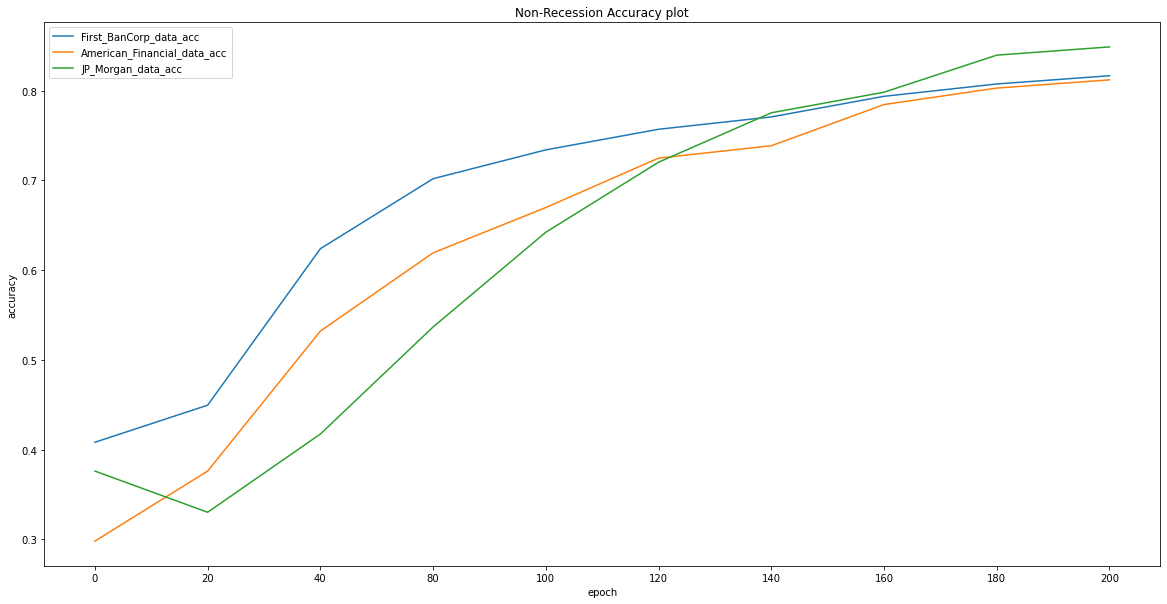

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

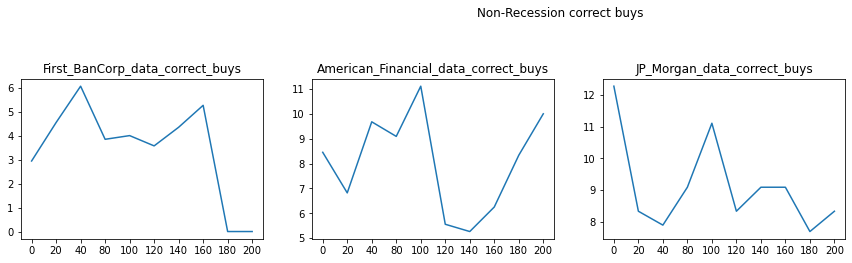

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

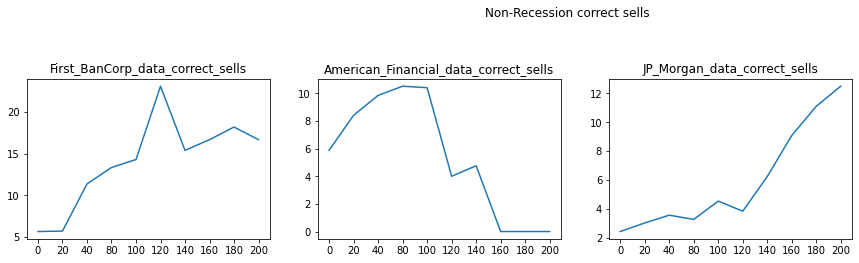

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

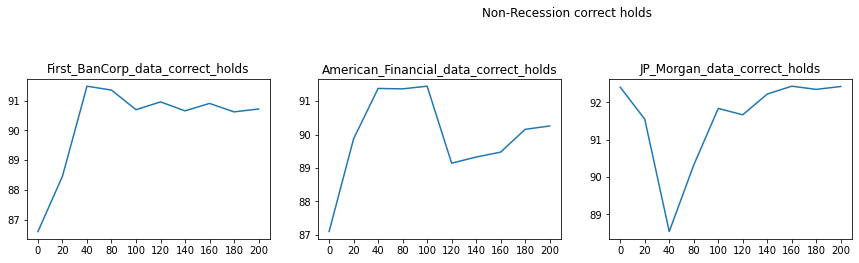

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

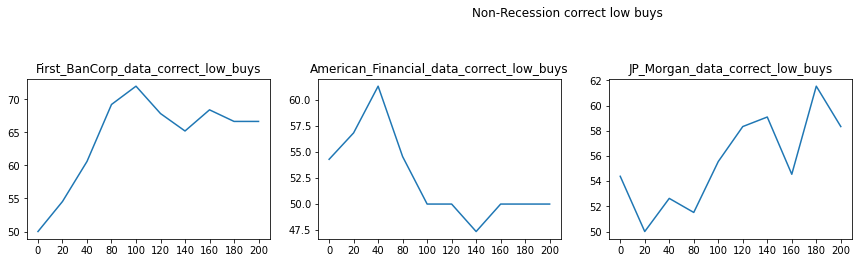

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

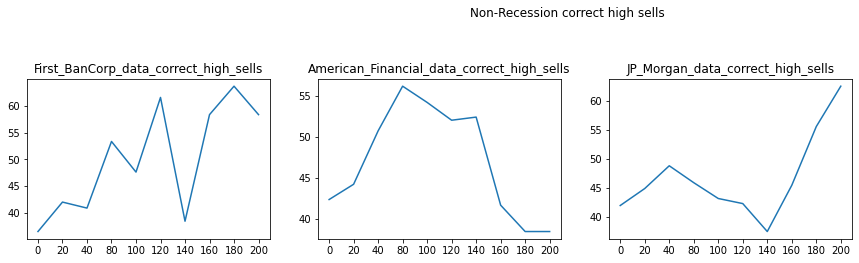

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

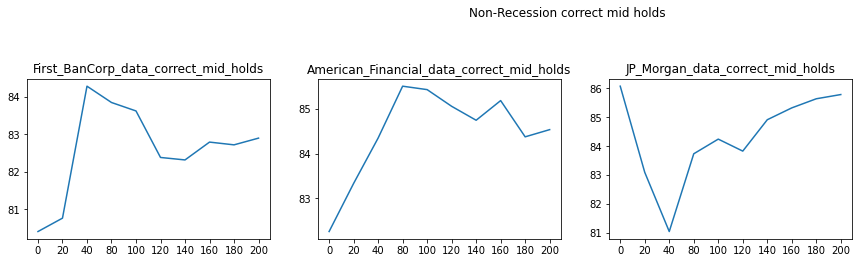

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

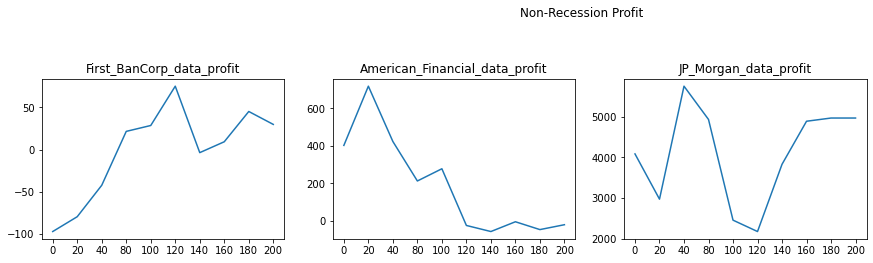

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

In [26]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


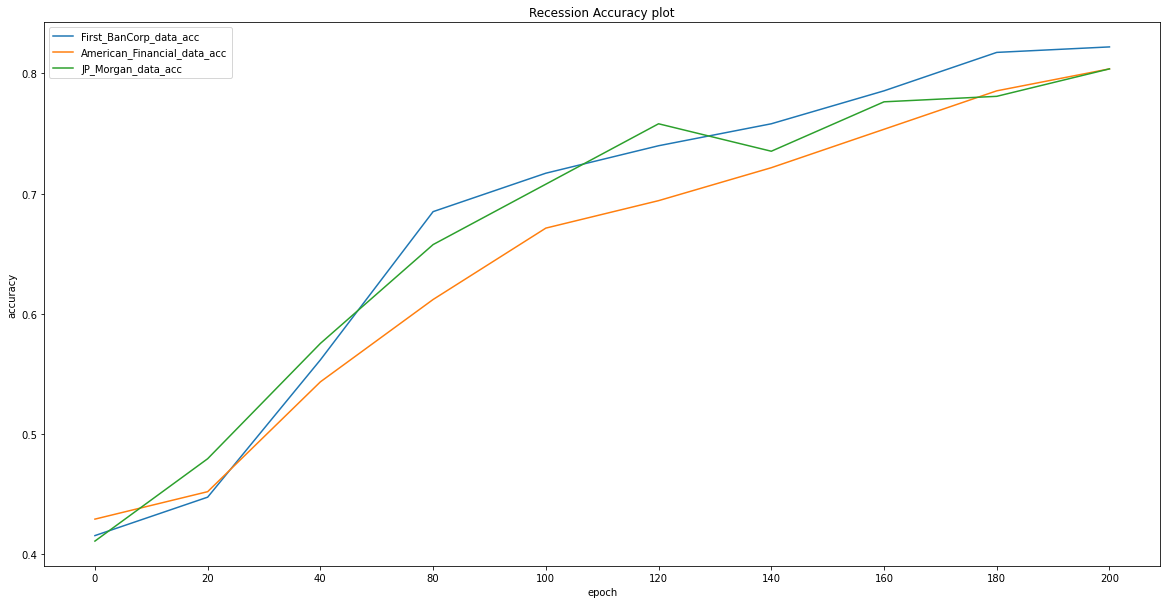

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

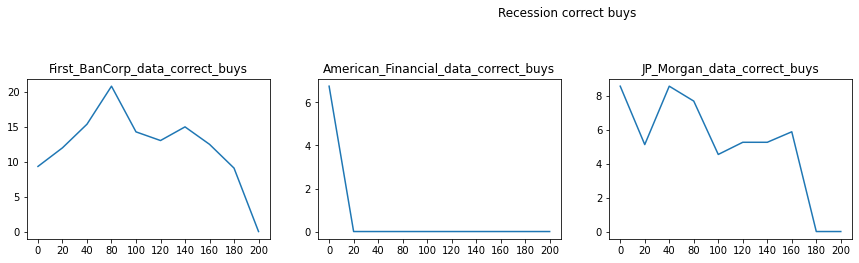

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

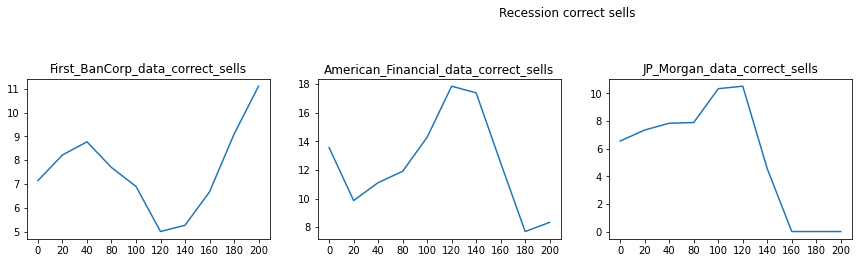

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

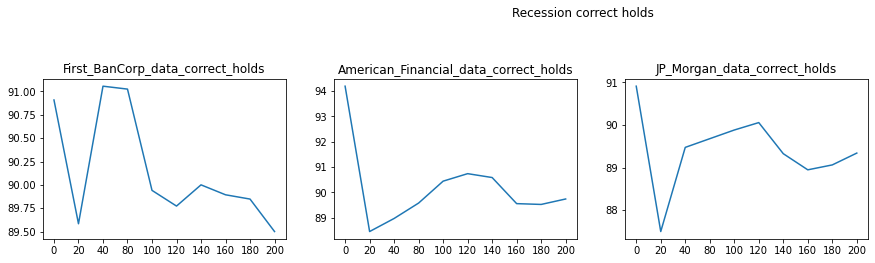

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

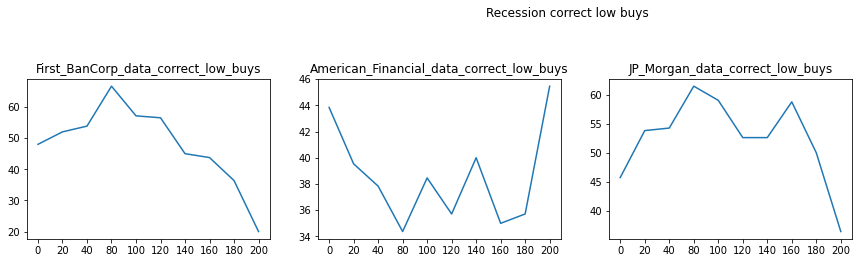

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

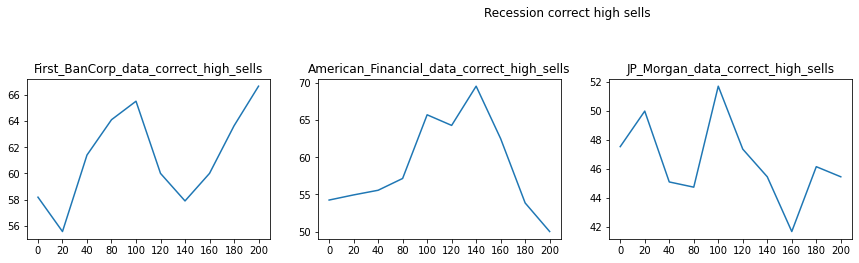

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

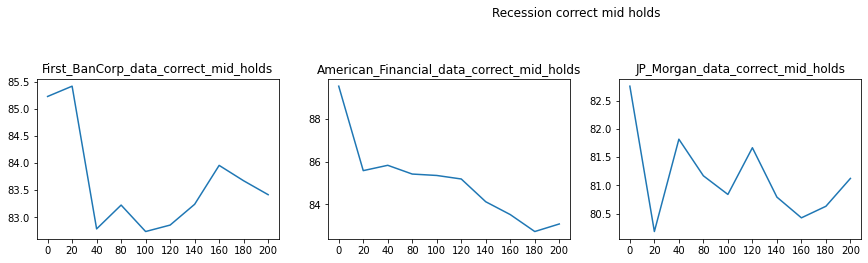

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

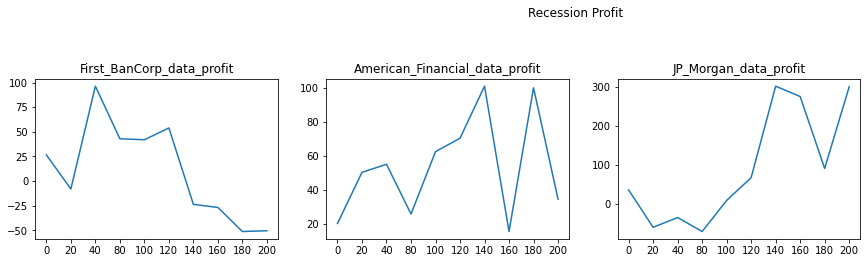

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

## Train American Financial Group, Inc Stock Data

In [35]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d     EMA_12    willr_14      OBV_7  labels
Date                                                             
2000-01-21    15.000000  16.189452 -100.000000  -550650.0     2.0
2000-01-24    15.166667  16.032100  -93.103439  -477300.0     2.0
2000-01-25    14.875000  15.854085  -92.187507  -762150.0     2.0
2000-01-26    14.708333  15.677815  -95.454544 -1036650.0     2.0
2000-01-27    14.666667  15.522254  -88.888864 -1157250.0     2.0


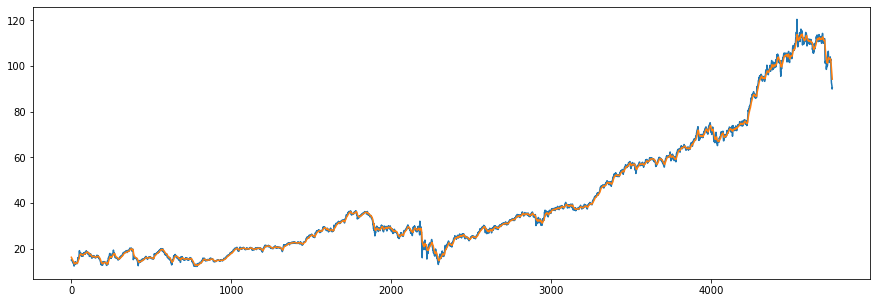

(4745, 15, 4)

In [36]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/AFG_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [37]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [38]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [39]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [41]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['FBP','AFG','JPM']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'AFGModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'AFGModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.272030651340996, 2: 0.36697602474864655}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 3s 97ms/step - loss: 0.2927 - accuracy: 0.5140 - mse: 0.4573 - weighted_accuracy: 0.3123 - weighted_mse: 0.5308 - val_loss: 0.2992 - val_accuracy: 0.0453 - val_mse: 0.3541 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3541
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2122 - accuracy: 0.3527 - mse: 0.7833 - weighted_accuracy: 0.4460 - weighted_mse: 0.7677 - val_loss: 0.2897 - val_accuracy: 0.0453 - val_mse: 0.3845 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3845
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1905 - accuracy: 0.3003 - mse: 1.0555 - weighted_accuracy: 0.4777 - weighted_mse: 1.0282 - val_loss: 0.2779 - val_accuracy: 0.0453 - val_mse: 0.4234 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4234
Epoch 4/20
30/30 [==============================] - 0s 8

7/7 [==============================] - 0s 3ms/step - loss: 0.1841 - accuracy: 0.4384 - mse: 1.3892 - weighted_accuracy: 0.4384 - weighted_mse: 1.3892
Test loss: 0.18412458896636963
Test accuracy: 0.4383561611175537


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 94
actual holds but predicted sell: 18
actual predicted holds: 85
Percentage buys correct: 7.766990291262136%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 89.47368421052632%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 48.54368932038835%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 84.04255319148936%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from 

number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 89
actual holds but predicted sell: 25
actual predicted holds: 83
Percentage buys correct: 6.122448979591836%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 91.20879120879121%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 45.36082474226804%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9747668796402857
Shares owned at the moment: 102
Cash capital at the moment: $0.30035616695175804


Price increase from previously bought: -62.582487735908465%
Share price: $0.36573653390672956
Shares owned at the moment: 0
Cash capital at the moment: $37.50289352767733


Share price: $0.3738785831824538
Shares owned at

2        1576.179166  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1845 - accuracy: 0.4292 - mse: 1.3786 - weighted_accuracy: 0.4292 - weighted_mse: 1.3786
Test loss: 0.18448927998542786
Test accuracy: 0.4292237460613251


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 93
actual holds but predicted sell: 22
actual predicted holds: 82
Percentage buys correct: 7.766990291262136%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 91.11111111111111%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.01960784313726%
Percentage high sells correct: 61.53846153846154%
Percentage mid holds correct: 84.44444444444444%


Capital: 100
Share price: $0.9728624318115608
Shares owned at the moment: 102
Cash capital at th

Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1354 - accuracy: 0.4557 - mse: 1.6111 - weighted_accuracy: 0.7257 - weighted_mse: 1.5390 - val_loss: 0.1992 - val_accuracy: 0.3498 - val_mse: 1.6800 - val_weighted_accuracy: 0.3498 - val_weighted_mse: 1.6800
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1345 - accuracy: 0.4407 - mse: 1.6594 - weighted_accuracy: 0.7311 - weighted_mse: 1.5735 - val_loss: 0.1796 - val_accuracy: 0.4384 - val_mse: 1.5521 - val_weighted_accuracy: 0.4384 - val_weighted_mse: 1.5521
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1324 - accuracy: 0.4623 - mse: 1.6524 - weighted_accuracy: 0.7427 - weighted_mse: 1.5686 - val_loss: 0.1825 - val_accuracy: 0.4194 - val_mse: 1.7647 - val_weighted_accuracy: 0.4194 - val_weighted_mse: 1.7647
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1314 - accuracy: 0.4847 - mse: 1.6844 - weighted_accuracy: 0.7582 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.2033 - accuracy: 0.2752 - mse: 1.8431 - weighted_accuracy: 0.2752 - weighted_mse: 1.8431
Test loss: 0.20333079993724823
Test accuracy: 0.2752293646335602


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 73
actual holds but predicted sell: 71
actual predicted holds: 53
Percentage buys correct: 5.063291139240507%
Percentage sells correct: 3.9473684210526314%
Percentage holds correct: 84.12698412698413%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.282051282051285%
Percentage high sells correct: 43.421052631578945%
Percentage mid holds correct: 79.36507936507937%


Capital: 100
Share price: $0.23780379089936354
Shares owned at the moment: 419
Cash capital at the moment: $0.08620219510287086


Pr

1         -42.761652  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1849 - accuracy: 0.3807 - mse: 1.8477 - weighted_accuracy: 0.3807 - weighted_mse: 1.8477
Test loss: 0.18485821783542633
Test accuracy: 0.3807339370250702


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 69
actual predicted holds: 75
Percentage buys correct: 9.375%
Percentage sells correct: 2.7777777777777777%
Percentage holds correct: 91.46341463414635%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 48.4375%
Percentage high sells correct: 50.70422535211268%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.0578

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1289 - accuracy: 0.4905 - mse: 1.7135 - weighted_accuracy: 0.7566 - weighted_mse: 1.6328 - val_loss: 0.1860 - val_accuracy: 0.4289 - val_mse: 1.8438 - val_weighted_accuracy: 0.4289 - val_weighted_mse: 1.8438
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1279 - accuracy: 0.4942 - mse: 1.7272 - weighted_accuracy: 0.7544 - weighted_mse: 1.6576 - val_loss: 0.2091 - val_accuracy: 0.3646 - val_mse: 1.9177 - val_weighted_accuracy: 0.3646 - val_weighted_mse: 1.9177
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1267 - accuracy: 0.5097 - mse: 1.7647 - weighted_accuracy: 0.7619 - weighted_mse: 1.6903 - val_loss: 0.1803 - val_accuracy: 0.4415 - val_mse: 1.8829 - val_weighted_accuracy: 0.4415 - val_weighted_mse: 1.8829
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1271 - accuracy: 0.5026 - mse: 1.7555 - weighted_accuracy: 0.7647 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1679 - accuracy: 0.5616 - mse: 2.0253 - weighted_accuracy: 0.5616 - weighted_mse: 2.0253
Test loss: 0.16793452203273773
Test accuracy: 0.5616438388824463


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 54
actual holds but predicted sell: 29
actual predicted holds: 114
Percentage buys correct: 10.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 90.47619047619048%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 55.0%
Percentage high sells correct: 63.63636363636363%
Percentage mid holds correct: 84.0%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -71.37995053768424%


7/7 [==============================] - 0s 3ms/step - loss: 0.1750 - accuracy: 0.4749 - mse: 2.0835 - weighted_accuracy: 0.4749 - weighted_mse: 2.0835
Test loss: 0.17497770488262177
Test accuracy: 0.47488585114479065


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 60
actual holds but predicted sell: 43
actual predicted holds: 94
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 10.416666666666666%
Percentage holds correct: 88.67924528301887%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 43.75%
Percentage high sells correct: 60.416666666666664%
Percentage mid holds correct: 82.0754716981132%


Capital: 100
Share price: $0.9747668796402857
Shares owned at the moment: 102
Cash capital at the moment: $0.30035616695175804


Price increase

2        1576.179166  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1889 - accuracy: 0.4521 - mse: 2.1272 - weighted_accuracy: 0.4521 - weighted_mse: 2.1272
Test loss: 0.1888764649629593
Test accuracy: 0.45205479860305786


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 80
actual holds but predicted sell: 31
actual predicted holds: 86
Percentage buys correct: 8.791208791208792%
Percentage sells correct: 13.88888888888889%
Percentage holds correct: 93.47826086956522%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.77777777777778%
Percentage high sells correct: 61.111111111111114%
Percentage mid holds correct: 84.78260869565217%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the 

30/30 [==============================] - 0s 8ms/step - loss: 0.1012 - accuracy: 0.6494 - mse: 2.2783 - weighted_accuracy: 0.8459 - weighted_mse: 2.2291 - val_loss: 0.1756 - val_accuracy: 0.5374 - val_mse: 2.5181 - val_weighted_accuracy: 0.5374 - val_weighted_mse: 2.5181
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1006 - accuracy: 0.6320 - mse: 2.3267 - weighted_accuracy: 0.8504 - weighted_mse: 2.2632 - val_loss: 0.1651 - val_accuracy: 0.5985 - val_mse: 2.4608 - val_weighted_accuracy: 0.5985 - val_weighted_mse: 2.4608
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0995 - accuracy: 0.6525 - mse: 2.3483 - weighted_accuracy: 0.8561 - weighted_mse: 2.2935 - val_loss: 0.1735 - val_accuracy: 0.5469 - val_mse: 2.3631 - val_weighted_accuracy: 0.5469 - val_weighted_mse: 2.3631
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0993 - accuracy: 0.6430 - mse: 2.3528 - weighted_accuracy: 0.8435 - weighted_mse: 2.3104

7/7 [==============================] - 0s 3ms/step - loss: 0.1990 - accuracy: 0.4725 - mse: 2.6350 - weighted_accuracy: 0.4725 - weighted_mse: 2.6350
Test loss: 0.1989946812391281
Test accuracy: 0.4724770784378052


number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 2
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 45
actual holds but predicted sell: 52
actual predicted holds: 100
Percentage buys correct: 0.0%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 87.71929824561404%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 40.35087719298246%
Percentage mid holds correct: 82.45614035087719%


Capital: 100
Share price: $0.23780379089936354
Shares owned at the moment: 419
Cash capital at the moment: $0.08620219510287086


Price increase from previously 

7/7 [==============================] - 0s 3ms/step - loss: 0.1724 - accuracy: 0.5229 - mse: 2.6900 - weighted_accuracy: 0.5229 - weighted_mse: 2.6900
Test loss: 0.17241977155208588
Test accuracy: 0.5229358077049255


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 4
actual holds but predicted buy: 36
actual holds but predicted sell: 57
actual predicted holds: 108
Percentage buys correct: 11.904761904761905%
Percentage sells correct: 1.7241379310344827%
Percentage holds correct: 91.52542372881356%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 87.28813559322033%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase

2         -31.900348  



RUNNING EPOCHS 80 - 100



Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0908 - accuracy: 0.6849 - mse: 2.5862 - weighted_accuracy: 0.8698 - weighted_mse: 2.5434 - val_loss: 0.1827 - val_accuracy: 0.5311 - val_mse: 2.9003 - val_weighted_accuracy: 0.5311 - val_weighted_mse: 2.9003
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0912 - accuracy: 0.6899 - mse: 2.6128 - weighted_accuracy: 0.8662 - weighted_mse: 2.5746 - val_loss: 0.2138 - val_accuracy: 0.4636 - val_mse: 2.9094 - val_weighted_accuracy: 0.4636 - val_weighted_mse: 2.9094
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0893 - accuracy: 0.7028 - mse: 2.6713 - weighted_accuracy: 0.8746 - weighted_mse: 2.6303 - val_loss: 0.1815 - val_accuracy: 0.5553 - val_mse: 2.9685 - val_weighted_accuracy: 0.5553 - val_weighted_mse: 2.9685
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0902 - accuracy: 0.6870 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1513 - accuracy: 0.6621 - mse: 3.3781 - weighted_accuracy: 0.6621 - weighted_mse: 3.3781
Test loss: 0.15133313834667206
Test accuracy: 0.6621004343032837


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 40
actual holds but predicted sell: 16
actual predicted holds: 141
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 88.67924528301887%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 72.22222222222223%
Percentage mid holds correct: 82.9113924050633%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bo

1         -42.761652  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1603 - accuracy: 0.6284 - mse: 3.4243 - weighted_accuracy: 0.6284 - weighted_mse: 3.4243
Test loss: 0.16030997037887573
Test accuracy: 0.6284403800964355


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 4
actual holds but predicted buy: 26
actual holds but predicted sell: 43
actual predicted holds: 132
Percentage buys correct: 12.903225806451612%
Percentage sells correct: 2.272727272727273%
Percentage holds correct: 92.3076923076923%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 51.61290322580645%
Percentage high sells correct: 47.72727272727273%
Percentage mid holds correct: 88.73239436619718%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital 

2         -31.900348  



RUNNING EPOCHS 100 - 120



Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0738 - accuracy: 0.7608 - mse: 3.3592 - weighted_accuracy: 0.9049 - weighted_mse: 3.3067 - val_loss: 0.1858 - val_accuracy: 0.5880 - val_mse: 3.9251 - val_weighted_accuracy: 0.5880 - val_weighted_mse: 3.9251
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0745 - accuracy: 0.7597 - mse: 3.3525 - weighted_accuracy: 0.8991 - weighted_mse: 3.2990 - val_loss: 0.2088 - val_accuracy: 0.5353 - val_mse: 3.6433 - val_weighted_accuracy: 0.5353 - val_weighted_mse: 3.6433
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0722 - accuracy: 0.7721 - mse: 3.4432 - weighted_accuracy: 0.9036 - weighted_mse: 3.3793 - val_loss: 0.1856 - val_accuracy: 0.5911 - val_mse: 3.8288 - val_weighted_accuracy: 0.5911 - val_weighted_mse: 3.8288
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0734 - accuracy: 0.7489 -

7/7 [==============================] - 0s 3ms/step - loss: 0.1439 - accuracy: 0.7215 - mse: 4.3819 - weighted_accuracy: 0.7215 - weighted_mse: 4.3819
Test loss: 0.14386358857154846
Test accuracy: 0.7214611768722534


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 25
actual holds but predicted sell: 16
actual predicted holds: 156
Percentage buys correct: 3.8461538461538463%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 88.63636363636364%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 65.38461538461539%
Percentage high sells correct: 64.70588235294117%
Percentage mid holds correct: 82.85714285714286%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase fro

1         -42.761652  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1582 - accuracy: 0.6927 - mse: 4.4676 - weighted_accuracy: 0.6927 - weighted_mse: 4.4676
Test loss: 0.15819290280342102
Test accuracy: 0.6926605701446533


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 5
actual holds but predicted buy: 21
actual holds but predicted sell: 33
actual predicted holds: 147
Percentage buys correct: 15.384615384615385%
Percentage sells correct: 0.0%
Percentage holds correct: 92.45283018867924%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 57.69230769230769%
Percentage high sells correct: 39.39393939393939%
Percentage mid holds correct: 87.9746835443038%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment:

Epoch 1/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0591 - accuracy: 0.8209 - mse: 4.3495 - weighted_accuracy: 0.9270 - weighted_mse: 4.1984 - val_loss: 0.1786 - val_accuracy: 0.6681 - val_mse: 4.9177 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 4.9177
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0598 - accuracy: 0.8151 - mse: 4.3194 - weighted_accuracy: 0.9230 - weighted_mse: 4.1718 - val_loss: 0.2152 - val_accuracy: 0.6017 - val_mse: 4.5313 - val_weighted_accuracy: 0.6017 - val_weighted_mse: 4.5313
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0578 - accuracy: 0.8277 - mse: 4.4424 - weighted_accuracy: 0.9295 - weighted_mse: 4.2774 - val_loss: 0.1904 - val_accuracy: 0.6396 - val_mse: 4.9150 - val_weighted_accuracy: 0.6396 - val_weighted_mse: 4.9150
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0591 - accuracy: 0.8143 - mse: 4.4120 - weighted_accuracy: 0.9318 - weighted_ms

7/7 [==============================] - 0s 6ms/step - loss: 0.1563 - accuracy: 0.7626 - mse: 5.7619 - weighted_accuracy: 0.7626 - weighted_mse: 5.7619
Test loss: 0.15634365379810333
Test accuracy: 0.7625570893287659


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 19
actual holds but predicted sell: 12
actual predicted holds: 166
Percentage buys correct: 0.0%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 88.77005347593582%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 68.42105263157895%
Percentage high sells correct: 61.53846153846154%
Percentage mid holds correct: 82.25806451612904%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously b

7/7 [==============================] - 0s 3ms/step - loss: 0.1672 - accuracy: 0.7385 - mse: 5.7832 - weighted_accuracy: 0.7385 - weighted_mse: 5.7832
Test loss: 0.16715441644191742
Test accuracy: 0.7385321259498596


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 18
actual holds but predicted sell: 25
actual predicted holds: 158
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 0.0%
Percentage holds correct: 91.86046511627907%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 48.0%
Percentage mid holds correct: 87.71929824561404%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previousl

30/30 [==============================] - 0s 10ms/step - loss: 0.0486 - accuracy: 0.8609 - mse: 5.5098 - weighted_accuracy: 0.9453 - weighted_mse: 5.1741 - val_loss: 0.2076 - val_accuracy: 0.6639 - val_mse: 5.6788 - val_weighted_accuracy: 0.6639 - val_weighted_mse: 5.6788
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0464 - accuracy: 0.8791 - mse: 5.6562 - weighted_accuracy: 0.9538 - weighted_mse: 5.3180 - val_loss: 0.1933 - val_accuracy: 0.6881 - val_mse: 6.0836 - val_weighted_accuracy: 0.6881 - val_weighted_mse: 6.0836
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0478 - accuracy: 0.8591 - mse: 5.6350 - weighted_accuracy: 0.9465 - weighted_mse: 5.2719 - val_loss: 0.1676 - val_accuracy: 0.7576 - val_mse: 6.1951 - val_weighted_accuracy: 0.7576 - val_weighted_mse: 6.1951
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0449 - accuracy: 0.8717 - mse: 5.7179 - weighted_accuracy: 0.9511 - weighted_mse: 5.349

7/7 [==============================] - 0s 3ms/step - loss: 0.1799 - accuracy: 0.7945 - mse: 7.4695 - weighted_accuracy: 0.7945 - weighted_mse: 7.4695
Test loss: 0.17988727986812592
Test accuracy: 0.7945205569267273


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 14
actual holds but predicted sell: 10
actual predicted holds: 173
Percentage buys correct: 0.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 89.17525773195877%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 64.28571428571429%
Percentage high sells correct: 63.63636363636363%
Percentage mid holds correct: 82.38341968911917%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bo

7/7 [==============================] - 0s 5ms/step - loss: 0.1827 - accuracy: 0.7661 - mse: 7.4375 - weighted_accuracy: 0.7661 - weighted_mse: 7.4375
Test loss: 0.18267162144184113
Test accuracy: 0.7660550475120544


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 15
actual holds but predicted sell: 21
actual predicted holds: 165
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 0.0%
Percentage holds correct: 91.66666666666667%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 87.15083798882682%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase 

Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0387 - accuracy: 0.8912 - mse: 6.9421 - weighted_accuracy: 0.9583 - weighted_mse: 6.3001 - val_loss: 0.1772 - val_accuracy: 0.7935 - val_mse: 7.7580 - val_weighted_accuracy: 0.7935 - val_weighted_mse: 7.7580
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0369 - accuracy: 0.8994 - mse: 7.0726 - weighted_accuracy: 0.9594 - weighted_mse: 6.4108 - val_loss: 0.1913 - val_accuracy: 0.7524 - val_mse: 7.7322 - val_weighted_accuracy: 0.7524 - val_weighted_mse: 7.7322
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0380 - accuracy: 0.8962 - mse: 7.1420 - weighted_accuracy: 0.9583 - weighted_mse: 6.5375 - val_loss: 0.1943 - val_accuracy: 0.7439 - val_mse: 8.0360 - val_weighted_accuracy: 0.7439 - val_weighted_mse: 8.0360
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0366 - accuracy: 0.9046 - mse: 7.3265 - weighted_accuracy: 0.9614 - weighted

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 10
actual holds but predicted sell: 10
actual predicted holds: 177
Percentage buys correct: 0.0%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 89.39393939393939%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 60.0%
Percentage high sells correct: 63.63636363636363%
Percentage mid holds correct: 82.74111675126903%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -68.56388568329146%
Share price: $0.31837789267390293
Shares owned at the moment: 0
Cash capital at the moment: $31.863035639966867


Share price: $0.3219429515777402
Shares owned at the moment: 98
Cash capital at the moment

7/7 [==============================] - 0s 4ms/step - loss: 0.1933 - accuracy: 0.7798 - mse: 8.9702 - weighted_accuracy: 0.7798 - weighted_mse: 8.9702
Test loss: 0.19328580796718597
Test accuracy: 0.7798165082931519


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 12
actual holds but predicted sell: 21
actual predicted holds: 168
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 0.0%
Percentage holds correct: 91.80327868852459%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 42.857142857142854%
Percentage high sells correct: 47.61904761904762%
Percentage mid holds correct: 86.81318681318682%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase 

Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0345 - accuracy: 0.9067 - mse: 8.2597 - weighted_accuracy: 0.9621 - weighted_mse: 7.3253 - val_loss: 0.2115 - val_accuracy: 0.7661 - val_mse: 8.8088 - val_weighted_accuracy: 0.7661 - val_weighted_mse: 8.8088
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0315 - accuracy: 0.9236 - mse: 8.4985 - weighted_accuracy: 0.9701 - weighted_mse: 7.5603 - val_loss: 0.2069 - val_accuracy: 0.7345 - val_mse: 8.8683 - val_weighted_accuracy: 0.7345 - val_weighted_mse: 8.8683
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0315 - accuracy: 0.9178 - mse: 8.3703 - weighted_accuracy: 0.9698 - weighted_mse: 7.3871 - val_loss: 0.1924 - val_accuracy: 0.8103 - val_mse: 9.2605 - val_weighted_accuracy: 0.8103 - val_weighted_mse: 9.2605
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0302 - accuracy: 0.9254 - mse: 8.5142 - weighted_accuracy: 0.9726 - weighted

7/7 [==============================] - 0s 7ms/step - loss: 0.2170 - accuracy: 0.8082 - mse: 11.0188 - weighted_accuracy: 0.8082 - weighted_mse: 11.0188
Test loss: 0.21701490879058838
Test accuracy: 0.8082191944122314


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 11
actual holds but predicted sell: 9
actual predicted holds: 177
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 88.94472361809045%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 63.63636363636363%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 82.32323232323232%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -64.86

1         -42.761652  


Non-Recession


7/7 [==============================] - 0s 5ms/step - loss: 0.2056 - accuracy: 0.7982 - mse: 10.4199 - weighted_accuracy: 0.7982 - weighted_mse: 10.4199
Test loss: 0.20556338131427765
Test accuracy: 0.7981651425361633


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 11
actual holds but predicted sell: 18
actual predicted holds: 172
Percentage buys correct: 15.384615384615385%
Percentage sells correct: 0.0%
Percentage holds correct: 91.97860962566845%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 46.15384615384615%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 86.55913978494624%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the mome

In [42]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


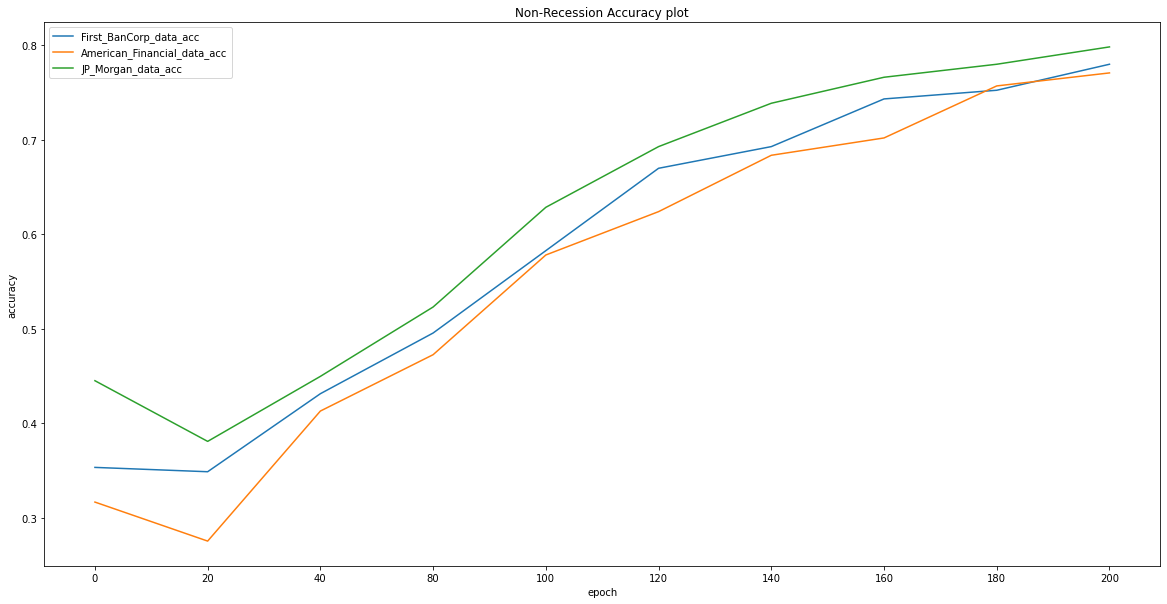

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

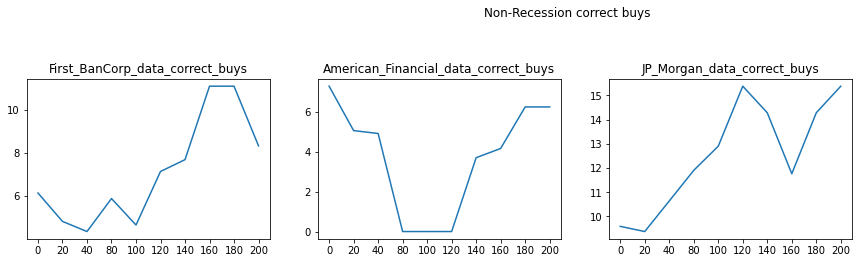

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

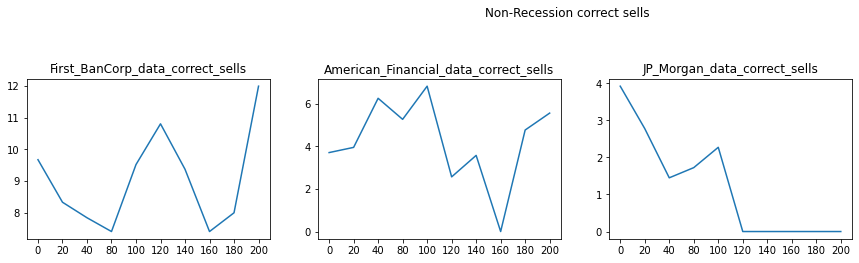

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

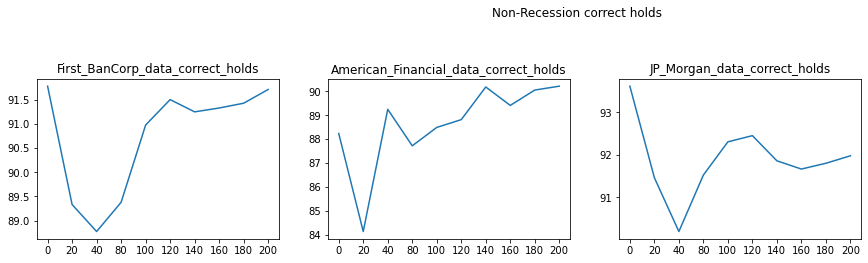

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

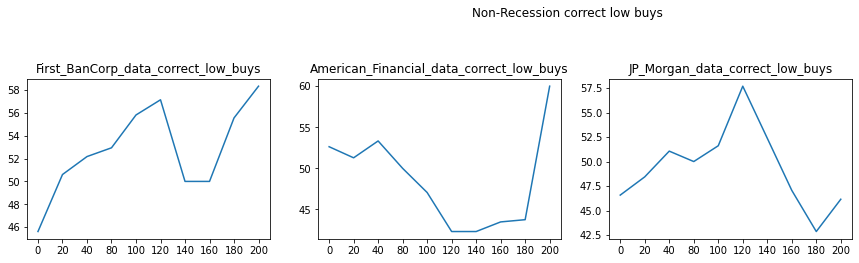

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

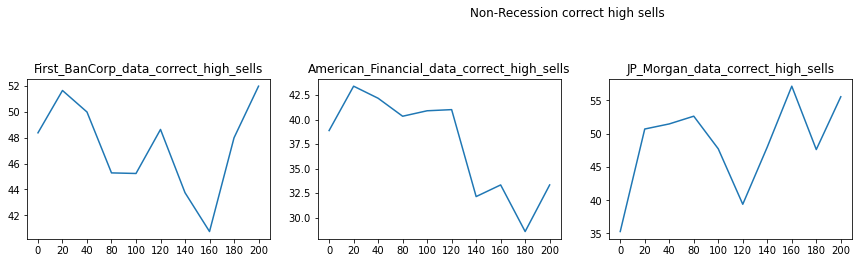

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

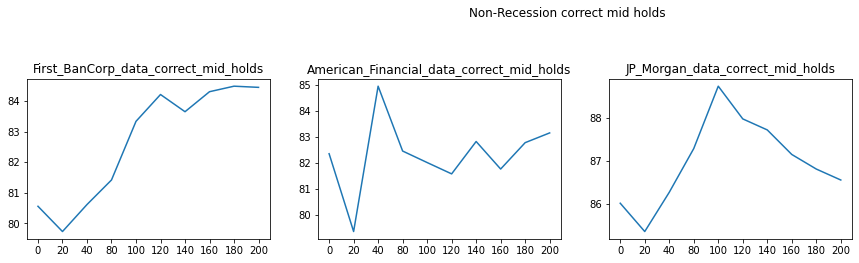

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

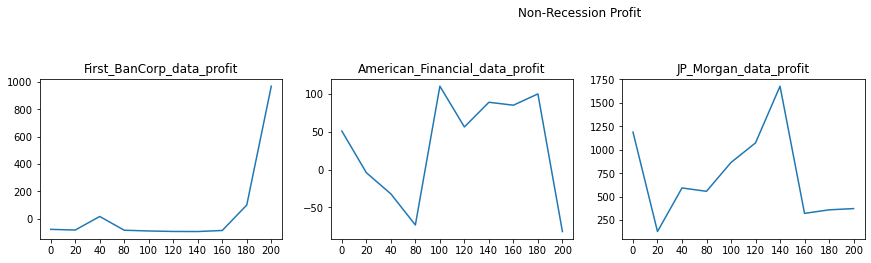

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

In [51]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


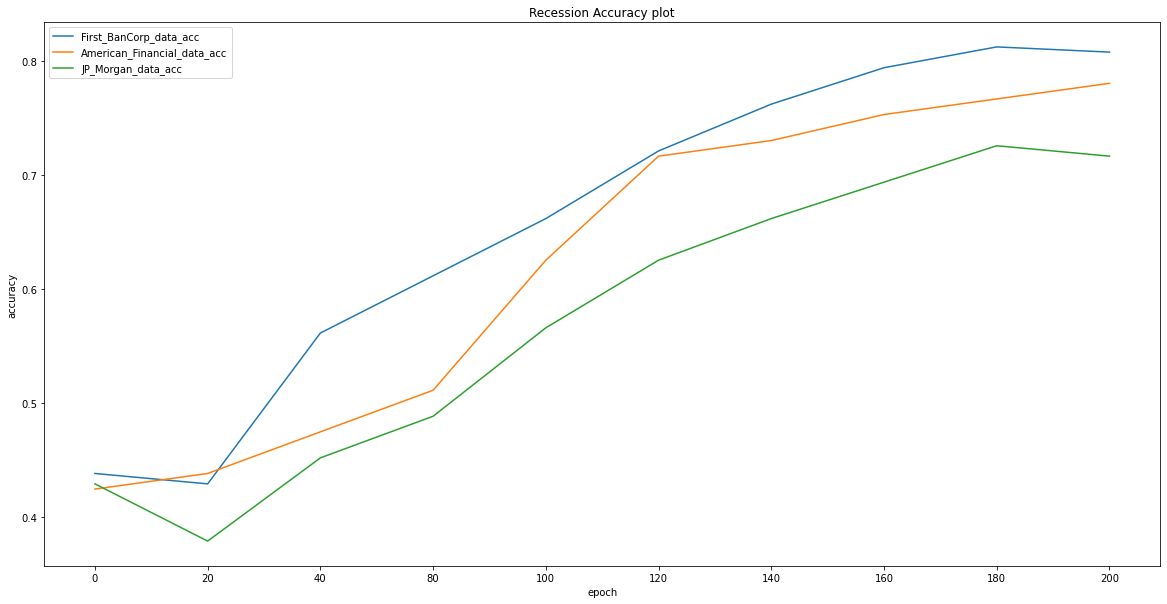

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

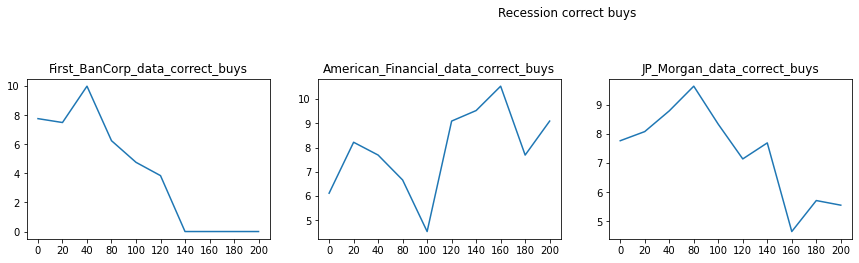

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

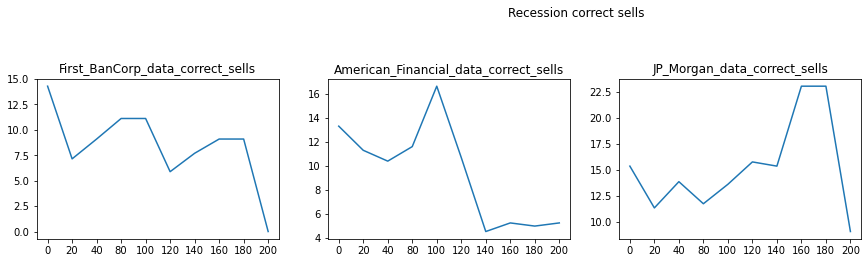

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

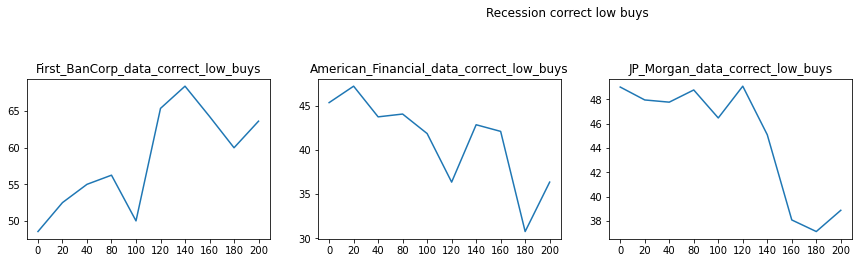

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

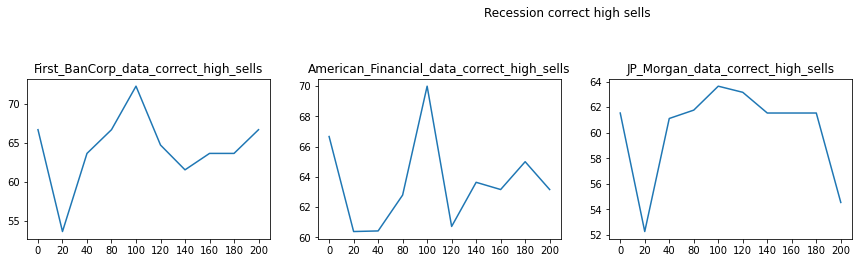

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

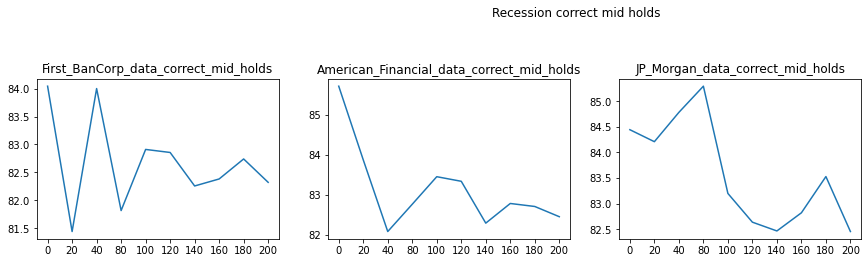

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

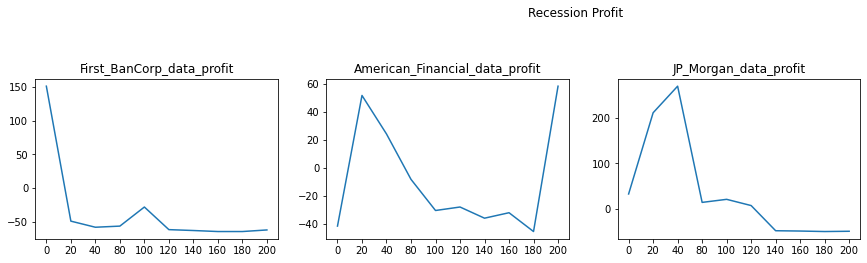

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

## Train JP Morgan Stock Data

In [59]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


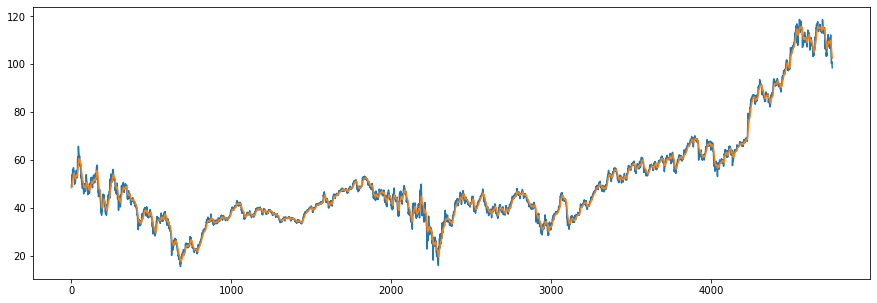

(4745, 15, 4)

In [60]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('variation 7/initial_indicators/JPM_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
    
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)

X.shape

In [61]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [62]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [63]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [65]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['FBP','AFG','JPM']
    for name in test_sets:
        
        print('\n')
        print("Non-Recession")
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('\n')
        print("Recession")
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("variation 7/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'JPMModel',epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('{}_{}_{}epochs.csv'.format(experiment,'JPMModel',epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 4s 134ms/step - loss: 0.2933 - accuracy: 0.4739 - mse: 0.4764 - weighted_accuracy: 0.3122 - weighted_mse: 0.5405 - val_loss: 0.2998 - val_accuracy: 0.0464 - val_mse: 0.3545 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3545
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2100 - accuracy: 0.3617 - mse: 0.7986 - weighted_accuracy: 0.4383 - weighted_mse: 0.7762 - val_loss: 0.2911 - val_accuracy: 0.0453 - val_mse: 0.3855 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3855
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1892 - accuracy: 0.2906 - mse: 1.0356 - weighted_accuracy: 0.4829 - weighted_mse: 1.0000 - val_loss: 0.2802 - val_accuracy: 0.0453 - val_mse: 0.4268 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4268
Epoch 4/20
30/30 [==============================] - 

7/7 [==============================] - 0s 4ms/step - loss: 0.1896 - accuracy: 0.3790 - mse: 1.3978 - weighted_accuracy: 0.3790 - weighted_mse: 1.3978
Test loss: 0.18960921466350555
Test accuracy: 0.37899544835090637


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 69
actual holds but predicted sell: 57
actual predicted holds: 71
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 9.375%
Percentage holds correct: 89.87341772151899%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 44.73684210526316%
Percentage high sells correct: 60.9375%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -69

7/7 [==============================] - 0s 6ms/step - loss: 0.1867 - accuracy: 0.3607 - mse: 1.3672 - weighted_accuracy: 0.3607 - weighted_mse: 1.3672
Test loss: 0.1867169290781021
Test accuracy: 0.3607305884361267


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 73
actual holds but predicted sell: 57
actual predicted holds: 67
Percentage buys correct: 6.329113924050633%
Percentage sells correct: 10.606060606060606%
Percentage holds correct: 90.54054054054055%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 53.03030303030303%
Percentage mid holds correct: 86.48648648648648%


Capital: 100
Share price: $0.821695020512681
Shares owned at the moment: 121
Cash capital at the moment: $0.30148349989001133


Price increase from

7/7 [==============================] - 0s 5ms/step - loss: 0.1821 - accuracy: 0.4155 - mse: 1.3413 - weighted_accuracy: 0.4155 - weighted_mse: 1.3413
Test loss: 0.18211863934993744
Test accuracy: 0.4155251085758209


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 52
actual holds but predicted sell: 66
actual predicted holds: 79
Percentage buys correct: 10.169491525423728%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 91.86046511627907%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 45.76271186440678%
Percentage high sells correct: 58.108108108108105%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price i

Epoch 13/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1291 - accuracy: 0.4536 - mse: 1.7843 - weighted_accuracy: 0.7431 - weighted_mse: 1.7199 - val_loss: 0.2027 - val_accuracy: 0.3151 - val_mse: 1.9551 - val_weighted_accuracy: 0.3151 - val_weighted_mse: 1.9551
Epoch 14/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1288 - accuracy: 0.4428 - mse: 1.8373 - weighted_accuracy: 0.7352 - weighted_mse: 1.7691 - val_loss: 0.1762 - val_accuracy: 0.4689 - val_mse: 1.8036 - val_weighted_accuracy: 0.4689 - val_weighted_mse: 1.8036
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1280 - accuracy: 0.4618 - mse: 1.8325 - weighted_accuracy: 0.7423 - weighted_mse: 1.7674 - val_loss: 0.1919 - val_accuracy: 0.3804 - val_mse: 1.8384 - val_weighted_accuracy: 0.3804 - val_weighted_mse: 1.8384
Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1277 - accuracy: 0.4573 - mse: 1.8792 - weighted_accuracy: 0.7499 - weight

7/7 [==============================] - 0s 4ms/step - loss: 0.1851 - accuracy: 0.4247 - mse: 1.9727 - weighted_accuracy: 0.4247 - weighted_mse: 1.9727
Test loss: 0.18506157398223877
Test accuracy: 0.42465752363204956


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 60
actual holds but predicted sell: 57
actual predicted holds: 80
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 10.76923076923077%
Percentage holds correct: 90.9090909090909%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 53.03030303030303%
Percentage high sells correct: 57.8125%
Percentage mid holds correct: 86.36363636363636%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously 

7/7 [==============================] - 0s 4ms/step - loss: 0.1975 - accuracy: 0.3836 - mse: 1.9759 - weighted_accuracy: 0.3836 - weighted_mse: 1.9759
Test loss: 0.1975349485874176
Test accuracy: 0.3835616409778595


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 70
actual holds but predicted sell: 56
actual predicted holds: 71
Percentage buys correct: 7.792207792207792%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 89.87341772151899%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.94736842105263%
Percentage high sells correct: 58.73015873015873%
Percentage mid holds correct: 88.60759493670886%


Capital: 100
Share price: $0.9769874796043578
Shares owned at the moment: 102
Cash capital at the moment: $0.07323209232647798


Price 

7/7 [==============================] - 0s 4ms/step - loss: 0.1924 - accuracy: 0.3333 - mse: 1.9524 - weighted_accuracy: 0.3333 - weighted_mse: 1.9524
Test loss: 0.19242708384990692
Test accuracy: 0.3333333432674408


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 79
actual holds but predicted sell: 59
actual predicted holds: 59
Percentage buys correct: 10.112359550561798%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 90.76923076923077%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.438202247191015%
Percentage high sells correct: 50.76923076923077%
Percentage mid holds correct: 76.5625%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increas

Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1157 - accuracy: 0.5335 - mse: 2.1026 - weighted_accuracy: 0.7913 - weighted_mse: 2.0554 - val_loss: 0.1825 - val_accuracy: 0.4584 - val_mse: 2.1685 - val_weighted_accuracy: 0.4584 - val_weighted_mse: 2.1685
Epoch 10/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1150 - accuracy: 0.5664 - mse: 2.1112 - weighted_accuracy: 0.7995 - weighted_mse: 2.0833 - val_loss: 0.1779 - val_accuracy: 0.5005 - val_mse: 2.1450 - val_weighted_accuracy: 0.5005 - val_weighted_mse: 2.1450
Epoch 11/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1128 - accuracy: 0.5493 - mse: 2.1412 - weighted_accuracy: 0.8066 - weighted_mse: 2.1024 - val_loss: 0.1729 - val_accuracy: 0.5068 - val_mse: 2.2278 - val_weighted_accuracy: 0.5068 - val_weighted_mse: 2.2278
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1137 - accuracy: 0.5653 - mse: 2.1384 - weighted_accuracy: 0.8050 - weighte

7/7 [==============================] - 0s 3ms/step - loss: 0.2111 - accuracy: 0.4312 - mse: 2.7984 - weighted_accuracy: 0.4312 - weighted_mse: 2.7984
Test loss: 0.21105022728443146
Test accuracy: 0.43119266629219055


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 48
actual holds but predicted sell: 66
actual predicted holds: 83
Percentage buys correct: 9.433962264150944%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 91.20879120879121%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 54.716981132075475%
Percentage high sells correct: 46.57534246575342%
Percentage mid holds correct: 83.51648351648352%


Capital: 100
Share price: $0.23780379089936354
Shares owned at the moment: 419
Cash capital at the moment: $0.08620219510287086


Pri

7/7 [==============================] - 0s 3ms/step - loss: 0.1995 - accuracy: 0.4037 - mse: 2.5722 - weighted_accuracy: 0.4037 - weighted_mse: 2.5722
Test loss: 0.19945977628231049
Test accuracy: 0.40366971492767334


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 1
actual holds but predicted buy: 46
actual holds but predicted sell: 76
actual predicted holds: 79
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 4.938271604938271%
Percentage holds correct: 92.94117647058823%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 53.84615384615385%
Percentage high sells correct: 48.75%
Percentage mid holds correct: 83.52941176470588%


Capital: 100
Share price: $0.13203826360778126
Shares owned at the moment: 755
Cash capital at the moment: $0.03696653130948846


Price increase f

Epoch 1/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1048 - accuracy: 0.6070 - mse: 2.3842 - weighted_accuracy: 0.8295 - weighted_mse: 2.3662 - val_loss: 0.1551 - val_accuracy: 0.6101 - val_mse: 2.3888 - val_weighted_accuracy: 0.6101 - val_weighted_mse: 2.3888
Epoch 2/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1055 - accuracy: 0.6106 - mse: 2.3763 - weighted_accuracy: 0.8195 - weighted_mse: 2.3573 - val_loss: 0.1825 - val_accuracy: 0.4921 - val_mse: 2.4775 - val_weighted_accuracy: 0.4921 - val_weighted_mse: 2.4775
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1031 - accuracy: 0.6220 - mse: 2.3988 - weighted_accuracy: 0.8293 - weighted_mse: 2.3925 - val_loss: 0.1876 - val_accuracy: 0.4816 - val_mse: 2.5823 - val_weighted_accuracy: 0.4816 - val_weighted_mse: 2.5823
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1033 - accuracy: 0.6149 - mse: 2.4344 - weighted_accuracy: 0.8326 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.5890 - mse: 3.0679 - weighted_accuracy: 0.5890 - weighted_mse: 3.0679
Test loss: 0.16460783779621124
Test accuracy: 0.5890411138534546


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 42
actual holds but predicted sell: 34
actual predicted holds: 121
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 89.62962962962963%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 54.34782608695652%
Percentage high sells correct: 57.89473684210526%
Percentage mid holds correct: 82.83582089552239%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.1930 - accuracy: 0.5525 - mse: 3.0469 - weighted_accuracy: 0.5525 - weighted_mse: 3.0469
Test loss: 0.1930273324251175
Test accuracy: 0.5525113940238953


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 56
actual holds but predicted sell: 31
actual predicted holds: 110
Percentage buys correct: 8.064516129032258%
Percentage sells correct: 16.216216216216218%
Percentage holds correct: 91.66666666666667%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.09836065573771%
Percentage high sells correct: 59.45945945945946%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.9747668796402857
Shares owned at the moment: 102
Cash capital at the moment: $0.30035616695175804


Price increase fr

2        1576.179166  


Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.1915 - accuracy: 0.4932 - mse: 3.0316 - weighted_accuracy: 0.4932 - weighted_mse: 3.0316
Test loss: 0.19146770238876343
Test accuracy: 0.4931506812572479


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 67
actual holds but predicted sell: 31
actual predicted holds: 99
Percentage buys correct: 4.285714285714286%
Percentage sells correct: 16.216216216216218%
Percentage holds correct: 88.39285714285714%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 59.45945945945946%
Percentage mid holds correct: 77.67857142857143%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at th

Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0779 - accuracy: 0.7360 - mse: 3.3825 - weighted_accuracy: 0.8958 - weighted_mse: 3.3705 - val_loss: 0.1961 - val_accuracy: 0.5595 - val_mse: 3.7009 - val_weighted_accuracy: 0.5595 - val_weighted_mse: 3.7009
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0762 - accuracy: 0.7542 - mse: 3.4578 - weighted_accuracy: 0.9025 - weighted_mse: 3.4409 - val_loss: 0.1599 - val_accuracy: 0.6596 - val_mse: 3.7984 - val_weighted_accuracy: 0.6596 - val_weighted_mse: 3.7984
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0752 - accuracy: 0.7468 - mse: 3.4519 - weighted_accuracy: 0.8961 - weighted_mse: 3.4188 - val_loss: 0.1581 - val_accuracy: 0.6575 - val_mse: 3.5579 - val_weighted_accuracy: 0.6575 - val_weighted_mse: 3.5579
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.7576 - mse: 3.5226 - weighted_accuracy: 0.8999 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.2099 - accuracy: 0.5367 - mse: 4.4968 - weighted_accuracy: 0.5367 - weighted_mse: 4.4968
Test loss: 0.2098679542541504
Test accuracy: 0.536697268486023


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 7
actual holds but predicted buy: 41
actual holds but predicted sell: 49
actual predicted holds: 107
Percentage buys correct: 10.869565217391305%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 91.45299145299145%
actual buys: 9
actual sells: 12
actual holds: 197


Percentage low buys correct: 60.0%
Percentage high sells correct: 47.27272727272727%
Percentage mid holds correct: 82.05128205128206%


Capital: 100
Share price: $0.23780379089936354
Shares owned at the moment: 419
Cash capital at the moment: $0.08620219510287086


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.1954 - accuracy: 0.5275 - mse: 3.8803 - weighted_accuracy: 0.5275 - weighted_mse: 3.8803
Test loss: 0.19541068375110626
Test accuracy: 0.5275229215621948


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 2
actual holds but predicted buy: 39
actual holds but predicted sell: 55
actual predicted holds: 107
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 5.172413793103448%
Percentage holds correct: 93.04347826086956%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 49.12280701754386%
Percentage mid holds correct: 85.21739130434783%


Capital: 100
Share price: $0.1480891521651453
Shares owned at the moment: 673
Cash capital at the moment: $0.06192459448757859


Pric




RUNNING EPOCHS 100 - 120



Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0709 - accuracy: 0.7616 - mse: 3.7635 - weighted_accuracy: 0.9052 - weighted_mse: 3.7150 - val_loss: 0.1509 - val_accuracy: 0.6870 - val_mse: 3.9841 - val_weighted_accuracy: 0.6870 - val_weighted_mse: 3.9841
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0729 - accuracy: 0.7695 - mse: 3.7471 - weighted_accuracy: 0.9007 - weighted_mse: 3.7079 - val_loss: 0.1608 - val_accuracy: 0.6660 - val_mse: 4.0999 - val_weighted_accuracy: 0.6660 - val_weighted_mse: 4.0999
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0693 - accuracy: 0.7790 - mse: 3.7459 - weighted_accuracy: 0.9077 - weighted_mse: 3.6955 - val_loss: 0.1976 - val_accuracy: 0.5564 - val_mse: 4.0914 - val_weighted_accuracy: 0.5564 - val_weighted_mse: 4.0914
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0683 - accuracy: 0.7756 - mse: 3.8579 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1580 - accuracy: 0.7032 - mse: 5.0044 - weighted_accuracy: 0.7032 - weighted_mse: 5.0044
Test loss: 0.1579713374376297
Test accuracy: 0.7031963467597961


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 30
actual holds but predicted sell: 20
actual predicted holds: 147
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 90.74074074074075%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 60.60606060606061%
Percentage high sells correct: 75.0%
Percentage mid holds correct: 83.85093167701864%


Capital: 100
Share price: $0.997522336335424
Shares owned at the moment: 99
Cash capital at the moment: $0.9737132467257084


Price increase from 

7/7 [==============================] - 0s 3ms/step - loss: 0.1966 - accuracy: 0.5826 - mse: 4.8795 - weighted_accuracy: 0.5826 - weighted_mse: 4.8795
Test loss: 0.19655203819274902
Test accuracy: 0.5825688242912292


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 2
actual holds but predicted buy: 31
actual holds but predicted sell: 50
actual predicted holds: 120
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 5.660377358490566%
Percentage holds correct: 93.02325581395348%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 52.83018867924528%
Percentage mid holds correct: 85.15625%


Capital: 100
Share price: $0.1401911236593889
Shares owned at the moment: 711
Cash capital at the moment: $0.050002383639466075


Price increas

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0573 - accuracy: 0.8224 - mse: 4.8095 - weighted_accuracy: 0.9294 - weighted_mse: 4.6405 - val_loss: 0.1557 - val_accuracy: 0.7239 - val_mse: 5.2262 - val_weighted_accuracy: 0.7239 - val_weighted_mse: 5.2262
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0587 - accuracy: 0.8285 - mse: 4.7691 - weighted_accuracy: 0.9296 - weighted_mse: 4.6243 - val_loss: 0.1591 - val_accuracy: 0.6997 - val_mse: 5.0661 - val_weighted_accuracy: 0.6997 - val_weighted_mse: 5.0661
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0554 - accuracy: 0.8322 - mse: 4.7585 - weighted_accuracy: 0.9349 - weighted_mse: 4.5862 - val_loss: 0.2080 - val_accuracy: 0.6080 - val_mse: 5.0943 - val_weighted_accuracy: 0.6080 - val_weighted_mse: 5.0943
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0545 - accuracy: 0.8288 - mse: 4.9070 - weighted_accuracy: 0.9355 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1680 - accuracy: 0.6986 - mse: 6.3083 - weighted_accuracy: 0.6986 - weighted_mse: 6.3083
Test loss: 0.16796159744262695
Test accuracy: 0.698630154132843


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 27
actual holds but predicted sell: 22
actual predicted holds: 148
Percentage buys correct: 10.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 89.6969696969697%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 56.666666666666664%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 82.92682926829268%


Capital: 100
Share price: $0.997522336335424
Shares owned at the moment: 99
Cash capital at the moment: $0.9737132467257084


Price increase from p

7/7 [==============================] - 0s 3ms/step - loss: 0.2024 - accuracy: 0.6895 - mse: 6.0901 - weighted_accuracy: 0.6895 - weighted_mse: 6.0901
Test loss: 0.20242300629615784
Test accuracy: 0.689497709274292


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 38
actual holds but predicted sell: 14
actual predicted holds: 145
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 12.5%
Percentage holds correct: 90.06211180124224%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 51.21951219512195%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.9747668796402857
Shares owned at the moment: 102
Cash capital at the moment: $0.30035616695175804


Price increase from previously b




RUNNING EPOCHS 140 - 160



Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0463 - accuracy: 0.8667 - mse: 6.1381 - weighted_accuracy: 0.9494 - weighted_mse: 5.7864 - val_loss: 0.1673 - val_accuracy: 0.7513 - val_mse: 6.3818 - val_weighted_accuracy: 0.7513 - val_weighted_mse: 6.3818
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0466 - accuracy: 0.8693 - mse: 6.0388 - weighted_accuracy: 0.9464 - weighted_mse: 5.7119 - val_loss: 0.1669 - val_accuracy: 0.7397 - val_mse: 6.6471 - val_weighted_accuracy: 0.7397 - val_weighted_mse: 6.6471
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0442 - accuracy: 0.8736 - mse: 6.0047 - weighted_accuracy: 0.9518 - weighted_mse: 5.6643 - val_loss: 0.2312 - val_accuracy: 0.6122 - val_mse: 6.1582 - val_weighted_accuracy: 0.6122 - val_weighted_mse: 6.1582
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0440 - accuracy: 0.8712 - mse: 6.2191 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1757 - accuracy: 0.7626 - mse: 7.9589 - weighted_accuracy: 0.7626 - weighted_mse: 7.9589
Test loss: 0.17567811906337738
Test accuracy: 0.7625570893287659


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 23
actual holds but predicted sell: 11
actual predicted holds: 163
Percentage buys correct: 8.0%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 90.05524861878453%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 56.0%
Percentage high sells correct: 76.92307692307692%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.997522336335424
Shares owned at the moment: 99
Cash capital at the moment: $0.9737132467257084


Price increase from previously b




Capital at the end of test period: $74.78492613874926
profit gained: -25.21507386125074%


Capital at the end of test period if Buy and Hold: $57.238347941758754
profit gained: -42.761652058241246%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.762557      8.000000      15.384615      90.055249   
1       0.730594     11.428571       8.333333      90.116279   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         56.000000           76.923077          83.333333     -52.247073   
1         51.428571           41.666667          83.040936     -25.215074   

   buy_n_hold profit  
0          -8.209536  
1         -42.761652  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.2070 - accuracy: 0.6606 - mse: 7.4200 - weighted_accuracy: 0.6606 - weighted_mse: 7.4200
Test loss: 0.2070460170507431
Test accuracy: 0.6605504751205444


number of predictions: 218
actual predicted buys: 5
actual buys but pre

2         -31.900348  



RUNNING EPOCHS 160 - 180



Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0371 - accuracy: 0.8999 - mse: 7.6733 - weighted_accuracy: 0.9634 - weighted_mse: 7.0181 - val_loss: 0.1812 - val_accuracy: 0.7850 - val_mse: 8.0316 - val_weighted_accuracy: 0.7850 - val_weighted_mse: 8.0316
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0366 - accuracy: 0.9041 - mse: 7.5747 - weighted_accuracy: 0.9630 - weighted_mse: 6.9392 - val_loss: 0.1754 - val_accuracy: 0.7945 - val_mse: 8.2362 - val_weighted_accuracy: 0.7945 - val_weighted_mse: 8.2362
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0358 - accuracy: 0.9044 - mse: 7.4744 - weighted_accuracy: 0.9631 - weighted_mse: 6.8652 - val_loss: 0.2390 - val_accuracy: 0.6565 - val_mse: 7.3121 - val_weighted_accuracy: 0.6565 - val_weighted_mse: 7.3121
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0355 - accuracy: 0.9004 

7/7 [==============================] - 0s 3ms/step - loss: 0.1901 - accuracy: 0.8082 - mse: 9.9849 - weighted_accuracy: 0.8082 - weighted_mse: 9.9849
Test loss: 0.19006747007369995
Test accuracy: 0.8082191944122314


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 15
actual holds but predicted sell: 8
actual predicted holds: 174
Percentage buys correct: 6.25%
Percentage sells correct: 20.0%
Percentage holds correct: 90.15544041450777%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 80.0%
Percentage mid holds correct: 83.85416666666667%


Capital: 100
Share price: $0.997522336335424
Shares owned at the moment: 99
Cash capital at the moment: $0.9737132467257084


Price increase from previously bought: -70.66554093184084%


7/7 [==============================] - 0s 3ms/step - loss: 0.1969 - accuracy: 0.7156 - mse: 9.2618 - weighted_accuracy: 0.7156 - weighted_mse: 9.2618
Test loss: 0.1969025433063507
Test accuracy: 0.7155963182449341


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 4
actual holds but predicted buy: 23
actual holds but predicted sell: 30
actual predicted holds: 148
Percentage buys correct: 20.689655172413794%
Percentage sells correct: 6.25%
Percentage holds correct: 94.26751592356688%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 51.724137931034484%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 87.17948717948718%


Capital: 100
Share price: $0.14910828396903564
Shares owned at the moment: 668
Cash capital at the moment: $0.12175439103307895


Price increase from previousl

30/30 [==============================] - 0s 13ms/step - loss: 0.0305 - accuracy: 0.9241 - mse: 9.4782 - weighted_accuracy: 0.9723 - weighted_mse: 8.4638 - val_loss: 0.2025 - val_accuracy: 0.7840 - val_mse: 10.2284 - val_weighted_accuracy: 0.7840 - val_weighted_mse: 10.2284
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0300 - accuracy: 0.9252 - mse: 9.2832 - weighted_accuracy: 0.9688 - weighted_mse: 8.2921 - val_loss: 0.1937 - val_accuracy: 0.8145 - val_mse: 10.4125 - val_weighted_accuracy: 0.8145 - val_weighted_mse: 10.4125
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0290 - accuracy: 0.9268 - mse: 9.1694 - weighted_accuracy: 0.9713 - weighted_mse: 8.2198 - val_loss: 0.2601 - val_accuracy: 0.6712 - val_mse: 8.6767 - val_weighted_accuracy: 0.6712 - val_weighted_mse: 8.6767
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0285 - accuracy: 0.9252 - mse: 9.4273 - weighted_accuracy: 0.9726 - weighted_mse: 8.39

7/7 [==============================] - 0s 4ms/step - loss: 0.2140 - accuracy: 0.8265 - mse: 12.2430 - weighted_accuracy: 0.8265 - weighted_mse: 12.2430
Test loss: 0.2139754295349121
Test accuracy: 0.8264840245246887


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 10
actual holds but predicted sell: 9
actual predicted holds: 178
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 90.35532994923858%
actual buys: 12
actual sells: 10
actual holds: 197


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 81.81818181818181%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $0.8263993389558189
Shares owned at the moment: 120
Cash capital at the moment: $0.5593675434463137


Pric

1         -42.761652  


Non-Recession


7/7 [==============================] - 0s 3ms/step - loss: 0.2129 - accuracy: 0.7339 - mse: 11.4013 - weighted_accuracy: 0.7339 - weighted_mse: 11.4013
Test loss: 0.21286985278129578
Test accuracy: 0.7339449524879456


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 4
actual holds but predicted buy: 17
actual holds but predicted sell: 29
actual predicted holds: 155
Percentage buys correct: 15.0%
Percentage sells correct: 6.451612903225806%
Percentage holds correct: 92.81437125748504%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 86.22754491017965%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


In [66]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


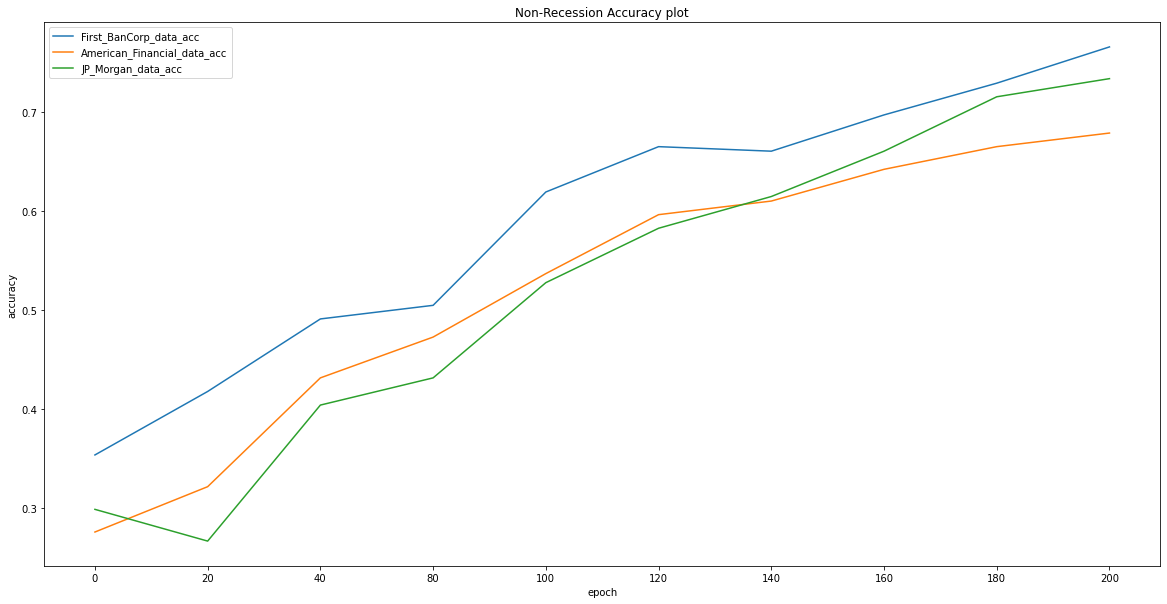

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

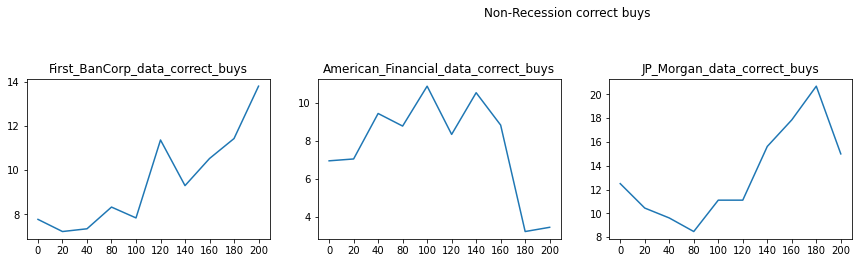

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

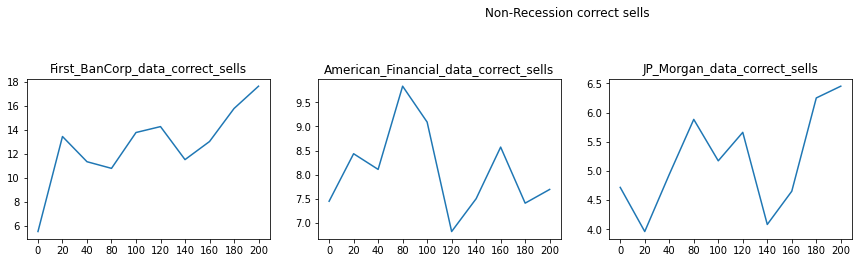

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

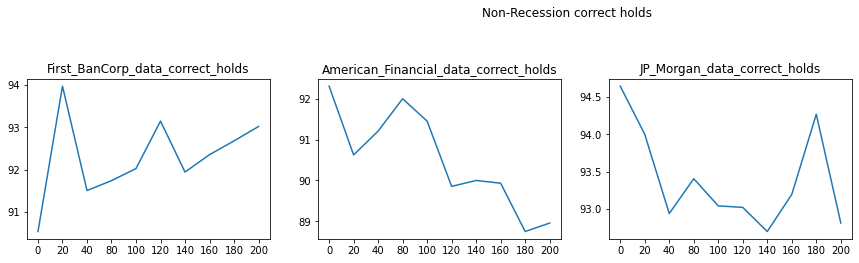

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

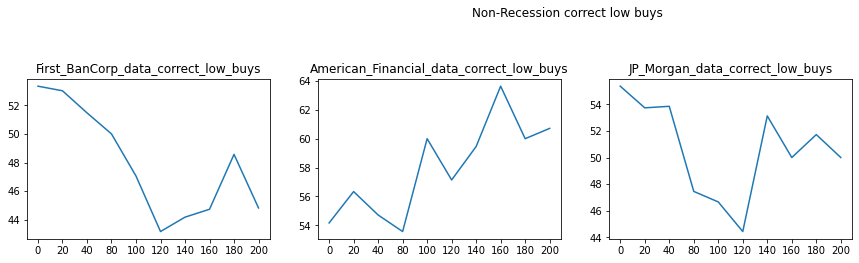

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

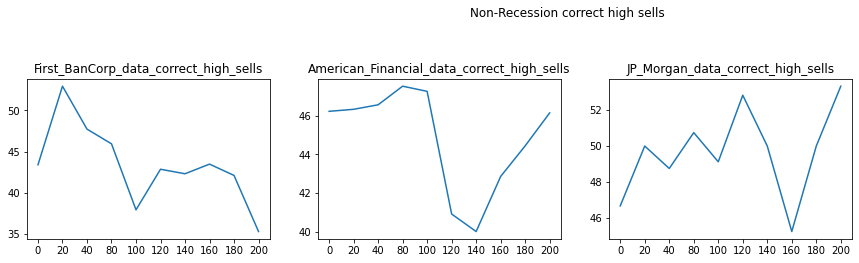

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

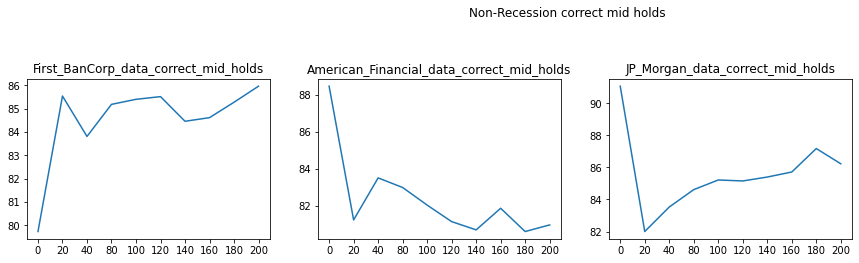

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

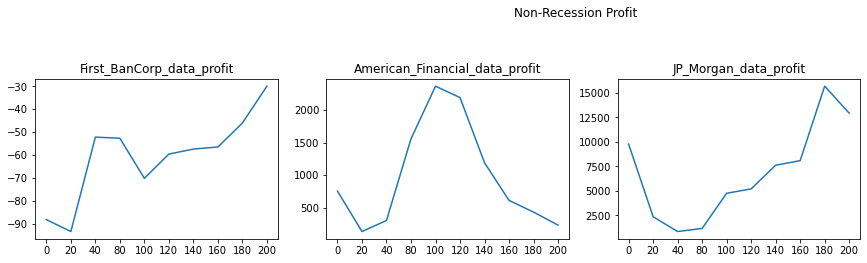

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")

In [75]:
First_BanCorp_data_acc = []
American_Financial_data_acc = []
JP_Morgan_data_acc = []

First_BanCorp_data_correct_buys = []
American_Financial_data_correct_buys = []
JP_Morgan_data_correct_buys = []

First_BanCorp_data_correct_sells = []
American_Financial_data_correct_sells = []
JP_Morgan_data_correct_sells = []

First_BanCorp_data_correct_holds = []
American_Financial_data_correct_holds = []
JP_Morgan_data_correct_holds = []

First_BanCorp_data_correct_low_buys = []
American_Financial_data_correct_low_buys = []
JP_Morgan_data_correct_low_buys = []

First_BanCorp_data_correct_high_sells = []
American_Financial_data_correct_high_sells = []
JP_Morgan_data_correct_high_sells = []

First_BanCorp_data_correct_mid_holds = []
American_Financial_data_correct_mid_holds = []
JP_Morgan_data_correct_mid_holds = []

First_BanCorp_data_profit = []
American_Financial_data_profit = []
JP_Morgan_data_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    First_BanCorp_data_acc.append(acc[0])
    American_Financial_data_acc.append(acc[1])
    JP_Morgan_data_acc.append(acc[2])
    
    First_BanCorp_data_correct_buys.append(correct_buys[0])
    American_Financial_data_correct_buys.append(correct_buys[1]) 
    JP_Morgan_data_correct_buys.append(correct_buys[2]) 

    First_BanCorp_data_correct_sells.append(correct_sells[0]) 
    American_Financial_data_correct_sells.append(correct_sells[1]) 
    JP_Morgan_data_correct_sells.append(correct_sells[2]) 

    First_BanCorp_data_correct_holds.append(correct_holds[0]) 
    American_Financial_data_correct_holds.append(correct_holds[1])  
    JP_Morgan_data_correct_holds.append(correct_holds[2])  

    First_BanCorp_data_correct_low_buys.append(correct_low_buys[0])  
    American_Financial_data_correct_low_buys.append(correct_low_buys[1])  
    JP_Morgan_data_correct_low_buys.append(correct_low_buys[2])  

    First_BanCorp_data_correct_high_sells.append(correct_high_sells[0]) 
    American_Financial_data_correct_high_sells.append(correct_high_sells[1]) 
    JP_Morgan_data_correct_high_sells.append(correct_high_sells[2]) 

    First_BanCorp_data_correct_mid_holds.append(correct_mid_holds[0])  
    American_Financial_data_correct_mid_holds.append(correct_mid_holds[1])  
    JP_Morgan_data_correct_mid_holds.append(correct_mid_holds[2])   

    First_BanCorp_data_profit.append(profit[0]) 
    American_Financial_data_profit.append(profit[1]) 
    JP_Morgan_data_profit.append(profit[2])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


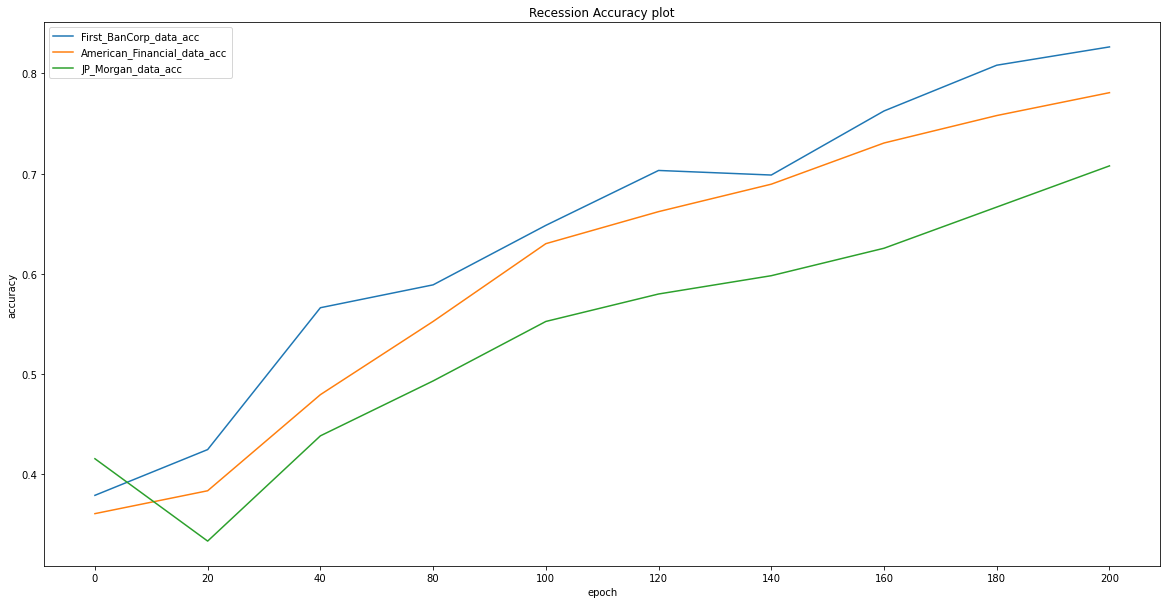

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(First_BanCorp_data_acc)
plt.plot(American_Financial_data_acc)
plt.plot(JP_Morgan_data_acc)

plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['First_BanCorp_data_acc','American_Financial_data_acc','JP_Morgan_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'JP_Morgan_data_correct_buys')

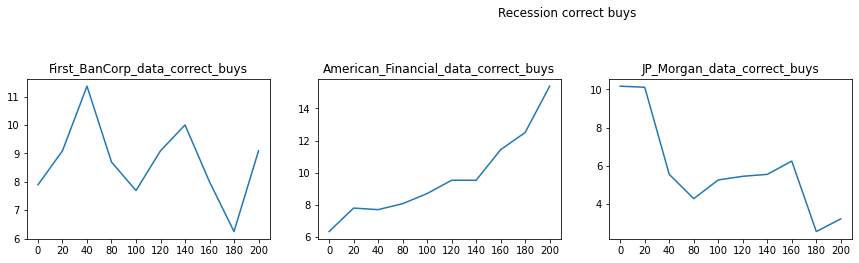

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_sells')

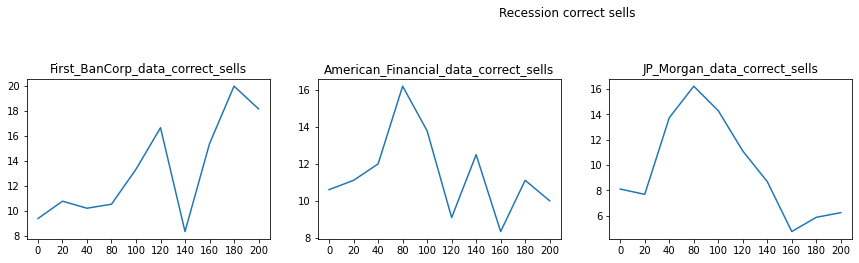

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_holds')

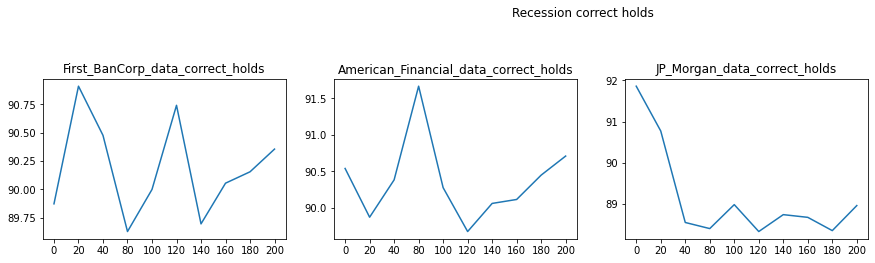

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_holds")

Text(0.5, 1.0, 'JP_Morgan_data_correct_low_buys')

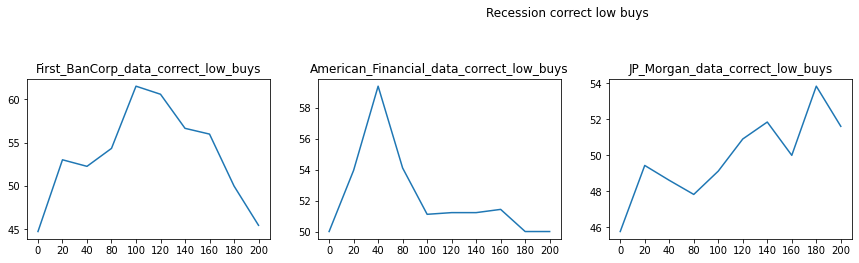

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_low_buys")

Text(0.5, 1.0, 'JP_Morgan_data_correct_high_sells')

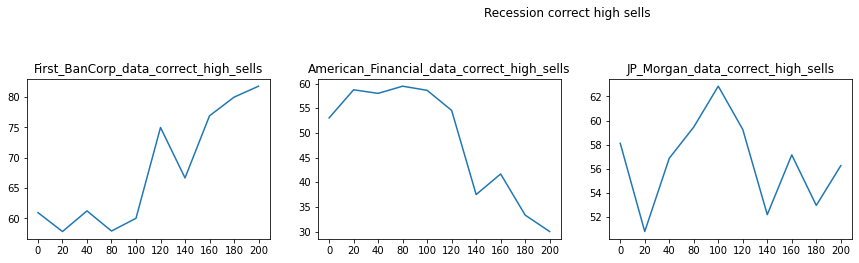

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_high_sells")

Text(0.5, 1.0, 'JP_Morgan_data_correct_mid_holds')

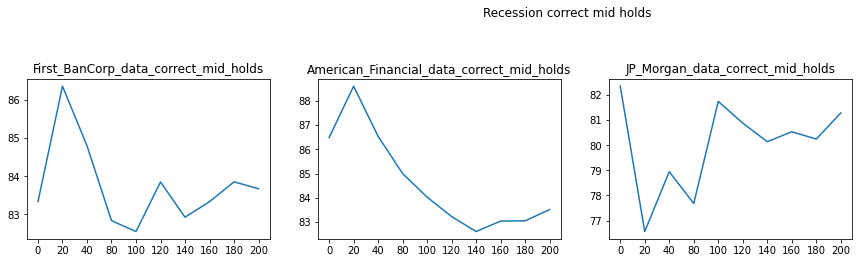

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_correct_mid_holds")

Text(0.5, 1.0, 'JP_Morgan_data_profit')

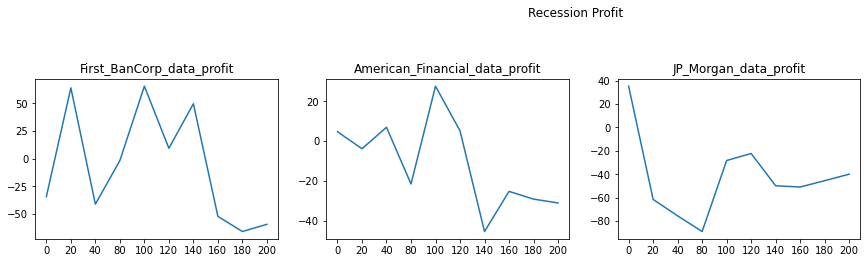

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(First_BanCorp_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("First_BanCorp_data_profit")

plt.subplot(3, 4, 2)
plt.plot(American_Financial_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("American_Financial_data_profit")

plt.subplot(3, 4, 3)
plt.plot(JP_Morgan_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JP_Morgan_data_profit")